In [41]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import h5py
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

In [48]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)

def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []

    with h5py.File(hdf5_file, 'r') as f:
        # Access the dataset
        dataset = f[dataset_name]

        # Extract the 'group', 'x', and 'y' fields
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]

        # Find unique groups
        unique_groups = np.unique(group_data)

        # Collect data for each group
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

def dbscan_filter(data, eps=0.05, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples,).fit(data)

    # Get core sample indices
    core_samples = clustering.core_sample_indices_

    return data.iloc[core_samples]

def find_clusters_k_means(data, k):
    kmeans = KMeans(init="k-means++", n_clusters=k, tol=1e-8, n_init=8, max_iter=1000)
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    distances = []
    for i in range(4):
        line_start = rectangle[i]
        line_end = rectangle[(i + 1) % 4]
        distances.append(np.mean([distance_to_line(point, line_start, line_end) for point in points]))
    closest_side = np.argmin(distances)
    return closest_side

def find_rotation_angle(rectangle, closest_side):
    # Find the angle of the closest side to make it parallel to the x-axis
    closest_line_start = rectangle[closest_side]
    closest_line_end = rectangle[(closest_side + 1) % 4]
    
    # Debugging: Print the coordinates of the closest line
    print(f"Closest line start: {closest_line_start}, end: {closest_line_end}")
    
    angle = np.arctan2(closest_line_end[1] - closest_line_start[1], closest_line_end[0] - closest_line_start[0])
    
    # Debugging: Print the initial calculated angle
    print(f"Initial calculated angle: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Ensure the longer side is at the top (if not, adjust the angle by 90 degrees)
    if rectangle[1][0] < rectangle[1][1]:
        angle += np.pi / 2
        print(f"Adjusted angle by 90 degrees: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Determine if the closest edge is the top or bottom edge
    if closest_line_start[1] < closest_line_end[1]:  # If the closest side is the bottom side
        angle += np.pi  # Rotate by 180 degrees to move it to the top
        print(f"Adjusted angle by 180 degrees (for bottom side): {angle} radians ({np.degrees(angle)} degrees)")
    
    final_angle = -angle  # Negate to rotate in the correct direction
    
    # Debugging: Print the final rotation angle
    print(f"Final rotation angle: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    return final_angle

def adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side):
    """
    Adjust the final orientation of the image by comparing the y-values of the closest side 
    before and after rotating by an additional 180 degrees.
    """
    # Calculate the y-values of the closest edge
    closest_line_start = rotated_rect[closest_side]
    closest_line_end = rotated_rect[(closest_side + 1) % 4]
    avg_y_before = (closest_line_start[1] + closest_line_end[1]) / 2
    
    # Perform a 180-degree rotation
    rotated_data_180 = rotate_points(rotated_com, np.pi, find_center_of_rectangle(rotated_rect))
    rotated_rect_180 = rotate_points(rotated_rect, np.pi, find_center_of_rectangle(rotated_rect))
    
    # Calculate the y-values of the rotated edge after the 180-degree rotation
    closest_line_start_180 = rotated_rect_180[closest_side]
    closest_line_end_180 = rotated_rect_180[(closest_side + 1) % 4]
    avg_y_after = (closest_line_start_180[1] + closest_line_end_180[1]) / 2
    
    # Compare the average y-values and choose the orientation with the higher y-value
    if avg_y_after < avg_y_before:
        print("Adjusting by 180 degrees")
        return rotated_data_180, rotated_rect_180, rotation_angle + np.pi
    else:
        return rotated_com, rotated_rect, rotation_angle

def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points

def find_middle_left_most_com(rotated_com):
    # Sort each com in rotated_com based on its x value and take the first 3
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    second_highest_com = None
    
    # Find the second highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_coms(rotated_com):
    # Sort each com in rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()]
    right_most_com = sorted_com[-1]
    second_right_most_com = sorted_com[-2]
    return right_most_com, second_right_most_com

def find_center_of_rectangle(rectangle):
    return np.mean(rectangle, axis=0)

def find_robot(rotated_com):
    
    #finding the center of the rectangle
    center_x, center_y = find_center_of_rectangle(rotated_com)
    
    distances = np.sqrt((rotated_com[:, 0] - center_x) ** 2 + (rotated_com[:, 1] - center_y) ** 2)
    closest_com_index = np.argmin(distances)
    closest_com = rotated_com[closest_com_index]
    
    return closest_com

def draw_line_between_points(p1, p2, color='white'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    
def intersection_between_point_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    if x1 == x2:
        return x1, y0
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    x = (m * y0 + x0 - m * c) / (m ** 2 + 1)
    y = m * x + c
    return x, y

def draw_line_between_point_and_line( p1, p2, p3):
    
    #finding the intersection point
    right_line = np.array([p1, p2])
    intersection_x, intersection_y = intersection_between_point_line(p3, right_line)
    intersection_point = np.array([intersection_x, intersection_y])
    
    #plotting the points between the points p3 and intersection point
    plt.plot([p3[0], intersection_point[0]], [p3[1], intersection_point[1]], color='magenta')

def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com):
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    right_line = np.array([right_most_com, second_right_most_com])
    intersection_point = intersection_between_point_line(robot_com, right_line)
    normalizing_point = intersection_between_point_line(second_highest_com, right_line)
    robot_distance = distance_point_to_line(robot_com, right_line)
    normalizing_distance = distance_point_to_line(second_highest_com, right_line)
    ratio = robot_distance / normalizing_distance

    plt.axes().set_facecolor('black')
    ax = plt.gca()
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=10)
    plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=10)
    plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=10)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=10)
    plt.scatter(robot_com[0], robot_com[1], color='magenta', s=10)

    draw_line_between_points(right_most_com, second_right_most_com, color='magenta')
    draw_line_between_point_and_line(right_most_com, second_right_most_com, robot_com)
    draw_line_between_point_and_line(second_right_most_com, right_most_com, second_highest_com)

    plt.grid(False)
    plt.show()

    return ratio


In [19]:
def plot_helper(data=None, labels=None, com=None, rotated_data=None, rotated_com=None, rotated_rect=None, second_highest_com=None, right_most_com=None, second_right_most_com=None, robot_com=None, title="Plot"):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    
    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)
    
    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')
    
    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    
    if rotated_com is not None and rotated_com.size > 0:
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100, label='Rotated COMs')
   
    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                     [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

    if second_highest_com is not None and len(second_highest_com) > 0:
        plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=100, label='Second Highest COM')
    

    if right_most_com is not None and len(right_most_com) > 0:
        plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=100, label='Right Most COM')
   
    if second_right_most_com is not None and len(second_right_most_com) > 0:
        plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=100, label='Second Right Most COM')
    
    if robot_com is not None and len(robot_com) > 0:
        plt.scatter(robot_com[0], robot_com[1], color='magenta', s=100, label='Robot COM')
    
    
    plt.title(title)
    plt.grid(False)
    plt.legend()
    plt.show()




def process_origami_ratio(filename, k):
    print("Starting process_origami_ratio")
    
    data = collect_data(filename)
    print("Data collected:\n", data.head())
    plot_helper(data=data, title="Initial Data")
    
    labels = find_clusters_k_means(data, k)
    print("K-Means labels:\n", labels)
    plot_helper(data=data, labels=labels, title="K-Means Clustering")

    com = find_com(data, labels)
    print("Centers of Mass (COM):\n", com)
    plot_helper(data=data, labels=labels, com=com, title="Centers of Mass")

    min_bounding_rect = minimum_bounding_rectangle(np.array(com))
    print("Minimum Bounding Rectangle:\n", min_bounding_rect)
    
    closest_side = find_closest_side(np.array(com), min_bounding_rect)
    print("Closest side of bounding rectangle:\n", closest_side)
    
    rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
    print("Rotation angle:\n", rotation_angle)
    
    rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Data:\n", rotated_data[:5])
    
    rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Centers of Mass (COM):\n", rotated_com)
    
    rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
    
    # Adjust the final orientation if needed
    rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
    if (rotation_angle != final_angle):
        #totae the data points by 180 degrees
        rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
    print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Final Adjusted Data and COMs")

    second_highest_com = find_middle_left_most_com(rotated_com)
    print("Second Highest COM:\n", second_highest_com)
    
    right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
    print("Right Most COM:\n", right_most_com)
    print("Second Right Most COM:\n", second_right_most_com)
    
    robot_com = find_robot(rotated_com)
    print("Robot COM:\n", robot_com)

    ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
    print("Ratio:\n", ratio)
    
    

    return ratio


In [49]:
def generate_ratio_histogram(ratios, bins=10, title="Histogram of Ratios", xlabel="Ratio", ylabel="Frequency"):
    """
    Generates a histogram of the provided ratios.
    
    :param ratios: List of ratio values to plot.
    :param bins: Number of bins for the histogram.
    :param title: Title of the histogram plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.hist(ratios, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    

def plot_ratio_points_and_lines(ratios, title="Points and Lines Plot of Ratios", xlabel="Index", ylabel="Ratio"):
    """
    Plots points for each ratio and connects them with lines to visualize peaks.
    
    :param ratios: List of ratio values to plot.
    :param title: Title of the plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(20, 12))
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Plotting the points
    plt.plot(range(len(ratios)), ratios, 'o-', color='red', markersize=8, linewidth=2)
    
    # Annotate the peak points
    max_ratio = max(ratios)
    min_ratio = min(ratios)
    
    for i, ratio in enumerate(ratios):
        plt.annotate(f"{ratio:.6f}", (i, ratio), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


def process_multiple_origami_ratio(filename, k):
    print("Starting process_multiple_origami_ratio")
    
    # Collect data for each group
    group_data_list = collect_group_data(filename, 'locs')
    
    ratios = []  # List to store the ratios for each group
    
    # Process each group
    for group_data in group_data_list:
        group_id = group_data['group']
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        print(f"\nProcessing Group {group_id}")
        print("Data collected:\n", data.head())
        plot_helper(data=data, title=f"Initial Data - Group {group_id}")
        
        data = dbscan_filter(data)

        labels = find_clusters_k_means(data, k)
        print("K-Means labels:\n", labels)
        plot_helper(data=data, labels=labels, title=f"K-Means Clustering - Group {group_id}")
    
        com = find_com(data, labels)
        print("Centers of Mass (COM):\n", com)
        plot_helper(data=data, labels=labels, com=com, title=f"Centers of Mass - Group {group_id}")
    
        min_bounding_rect = minimum_bounding_rectangle(np.array(com))
        print("Minimum Bounding Rectangle:\n", min_bounding_rect)
        
        closest_side = find_closest_side(np.array(com), min_bounding_rect)
        print("Closest side of bounding rectangle:\n", closest_side)
        
        rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
        print("Rotation angle:\n", rotation_angle)
        
        rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Data:\n", rotated_data[:5])
        
        rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Centers of Mass (COM):\n", rotated_com)
        
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
        
        # Adjust the final orientation if needed
        rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
        if (rotation_angle != final_angle):
            # Rotate the data points by 180 degrees
            rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
        print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
        
        plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Final Adjusted Data and COMs - Group {group_id}")

        second_highest_com = find_middle_left_most_com(rotated_com)
        print("Second Highest COM:\n", second_highest_com)
        
        right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
        print("Right Most COM:\n", right_most_com)
        print("Second Right Most COM:\n", second_right_most_com)
        
        robot_com = find_robot(rotated_com)
        print("Robot COM:\n", robot_com)
    
        ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
        print("Ratio:\n", ratio)
        
        ratios.append(ratio)  # Store the ratio for this group
    
    generate_ratio_histogram(ratios)  # Generate the histogram of all the collected ratios
    
    plot_ratio_points_and_lines(ratios)  # Plot the points and lines for the ratios
    
    #calculate the mean and standard deviation of the ratios
    mean_ratio = np.mean(ratios)
    std_dev = np.std(ratios)
    print(f"Mean Ratio: {mean_ratio}")
    print(f"Standard Deviation: {std_dev}")
    
    return ratios


Starting process_multiple_origami_ratio

Processing Group 0
Data collected:
            x         y
0  42.897629  5.893465
1  42.816818  5.834262
2  42.830162  5.812670
3  42.875660  5.817399
4  42.836132  5.822851


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


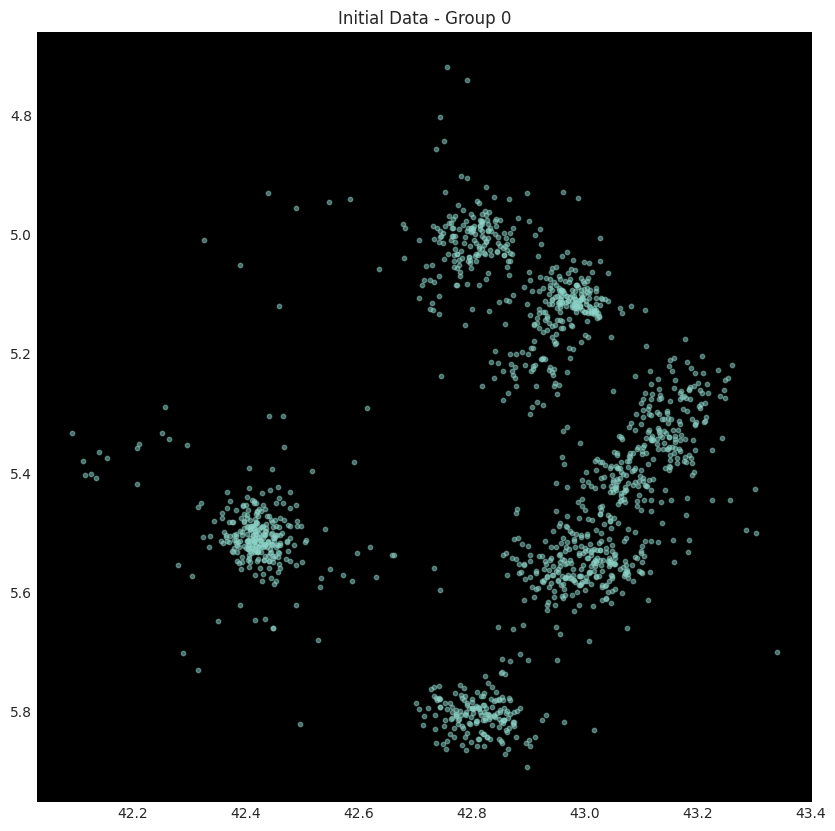

K-Means labels:
 [4 4 4 ... 2 4 6]


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


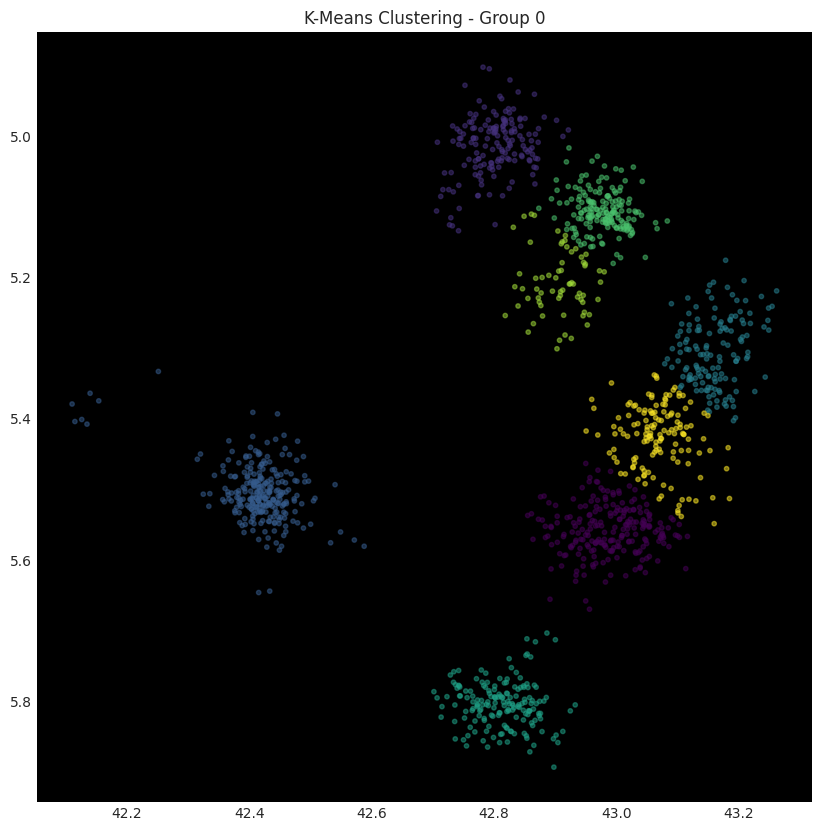

Centers of Mass (COM):
 [(np.float64(42.98896031652778), np.float64(5.558319799700498)), (np.float64(42.8017200893826), np.float64(5.013988724461308)), (np.float64(42.416344428697016), np.float64(5.5041689745826865)), (np.float64(43.16063340952699), np.float64(5.306536254748492)), (np.float64(42.813114790888555), np.float64(5.804361655698185)), (np.float64(42.97754990313686), np.float64(5.106965175456247)), (np.float64(42.906157060102984), np.float64(5.207751902666959)), (np.float64(43.06869203824523), np.float64(5.426977975994137))]


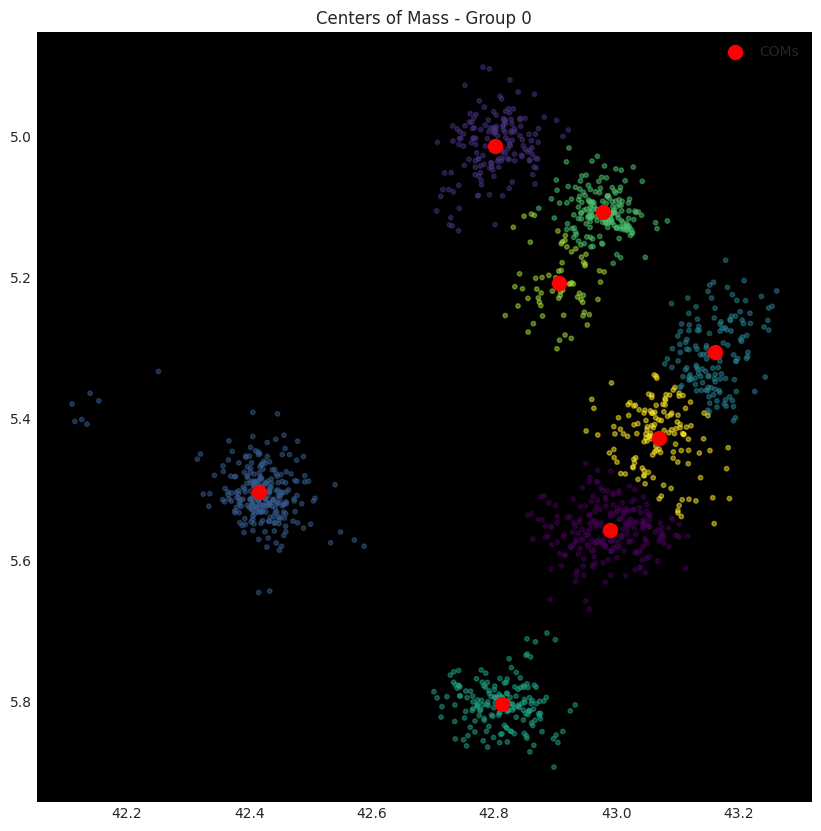

Minimum Bounding Rectangle:
 [[43.20853546  5.28172665]
 [42.8117651   4.98153397]
 [42.41634443  5.50416897]
 [42.81311479  5.80436166]]
Closest side of bounding rectangle:
 3
Closest line start: [42.81311479  5.80436166], end: [43.20853546  5.28172665]
Initial calculated angle: -0.9230906328148367 radians (-52.889197368350516 degrees)
Final rotation angle: 0.9230906328148367 radians (52.889197368350516 degrees)
Rotation angle:
 0.9230906328148367
Rotated Data:
 [[42.79304972  5.92552032]
 [42.79150437  5.82535589]
 [42.81677456  5.82296938]
 [42.84045502  5.86210576]
 [42.81225798  5.83387276]]
Rotated Centers of Mass (COM):
 [[43.1154237   5.79614181]
 [43.43653855  5.31839661]
 [42.81311479  5.30682536]
 [43.41979397  5.78113028]
 [42.81311479  5.80436166]
 [43.46848099  5.51471376]
 [43.34503111  5.51859061]
 [43.26827169  5.78047929]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.06468328640463 radians (232.88919736835055 degrees)


/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


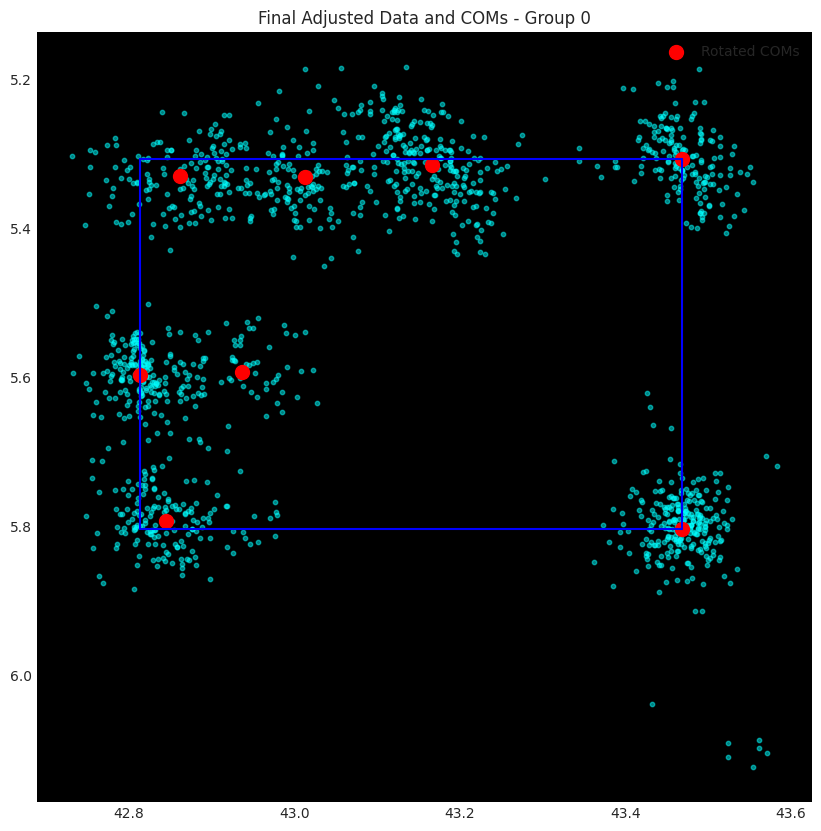

Second Highest COM:
 [42.81311479  5.59647325]
Right Most COM:
 [43.46848099  5.30682536]
Second Right Most COM:
 [43.46848099  5.80436166]
Robot COM:
 [42.93656467  5.5925964 ]


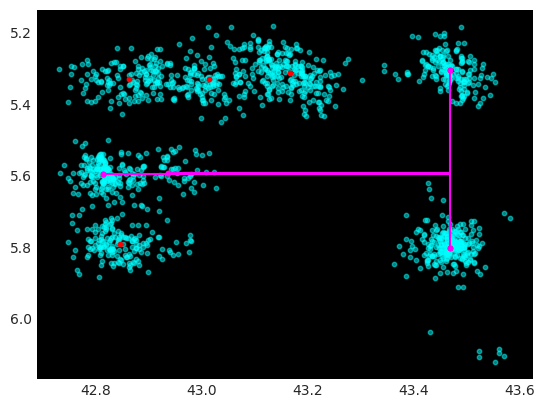

Ratio:
 0.8116322164400822

Processing Group 1
Data collected:
            x         y
0  74.181908  2.675268
1  74.218697  2.590031
2  74.369797  3.188938
3  74.364662  3.175110
4  74.386177  3.169834


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


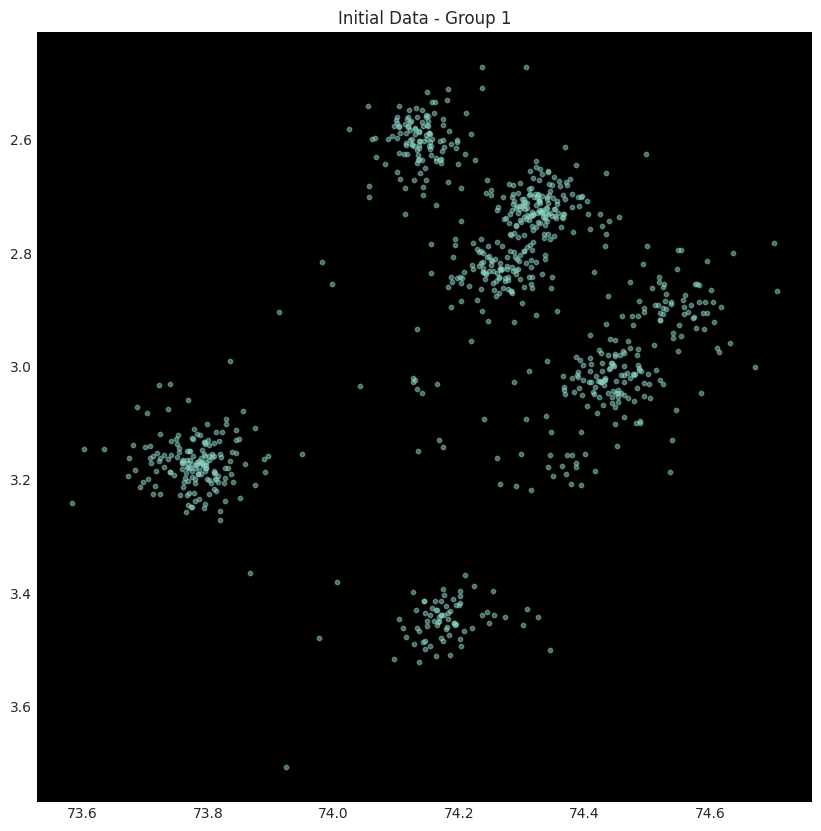

K-Means labels:
 [5 5 7 7 7 7 7 7 7 7 7 1 0 0 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 2 4 4
 4 1 1 3 3 3 4 4 4 4 4 4 4 3 3 1 1 1 1 1 1 1 5 5 2 2 5 5 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 4
 4 0 0 4 4 2 2 2 2 2 2 2 2 6 6 6 6 3 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 7 4 4 4 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 5 5 5 5 5 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 4 4 4 4 4 4 4 5
 5 5 2 2 2 0 2 6 4 3 3 3 3 3 3 3 3 5 6 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 2 2 3
 2 2 3 5 5 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6
 6 6 6 6 6 7 1 6 5 5 5 4 4 4 4 4 4 4 4 5 2 6 6 1 1 1 1 1 1 1 1 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 2 5 5 5 5 5 1 1 1 1 1 1 5 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 6 2 2 6 5 6 0 1 1 1 1 1 1 1 5 5 5 5 1 1 1 1 1 1 1 5 5 5 5 5 3 3 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 7 7 7 2 6 6 5 5 5 5 7 1 1 1 1 2 2 6 6
 6 6 6 6 6 6 2 6 5 5 2 2 2 2 4 4 4 2 2 2 2 6 6 6 6 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2

/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


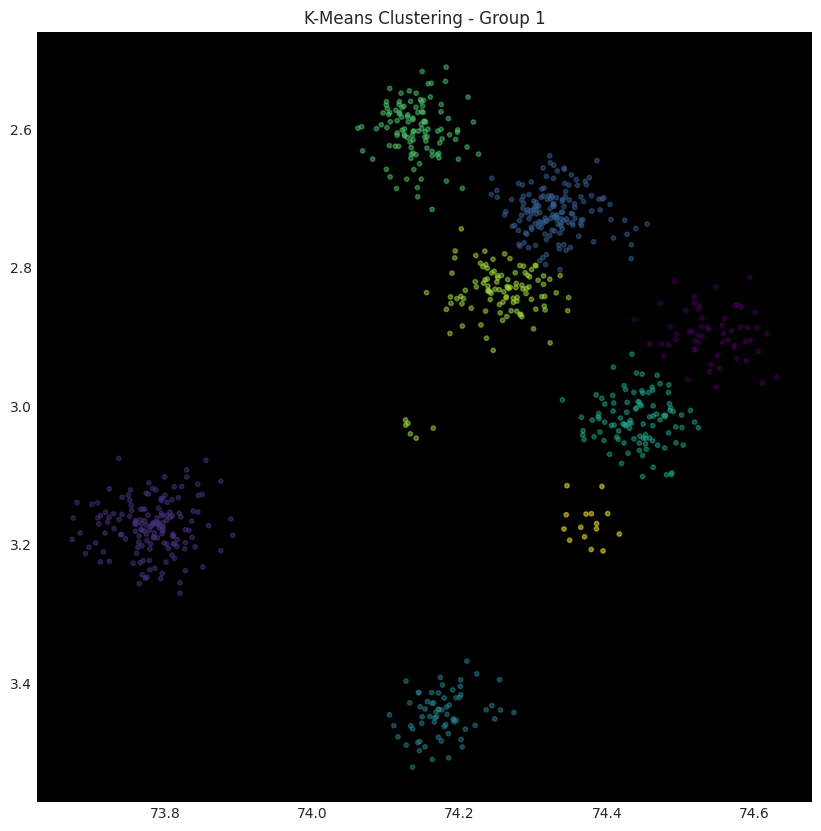

Centers of Mass (COM):
 [(np.float64(74.54322170389109), np.float64(2.8959983587265015)), (np.float64(73.78097762070693), np.float64(3.1739211128903673)), (np.float64(74.32957914278104), np.float64(2.7201730090302307)), (np.float64(74.17632715025944), np.float64(3.4453252749656564)), (np.float64(74.44177179429137), np.float64(3.020853547216619)), (np.float64(74.14095973968506), np.float64(2.601472333073616)), (np.float64(74.2524779284442), np.float64(2.843854440583123)), (np.float64(74.37501729329428), np.float64(3.169285011291504))]


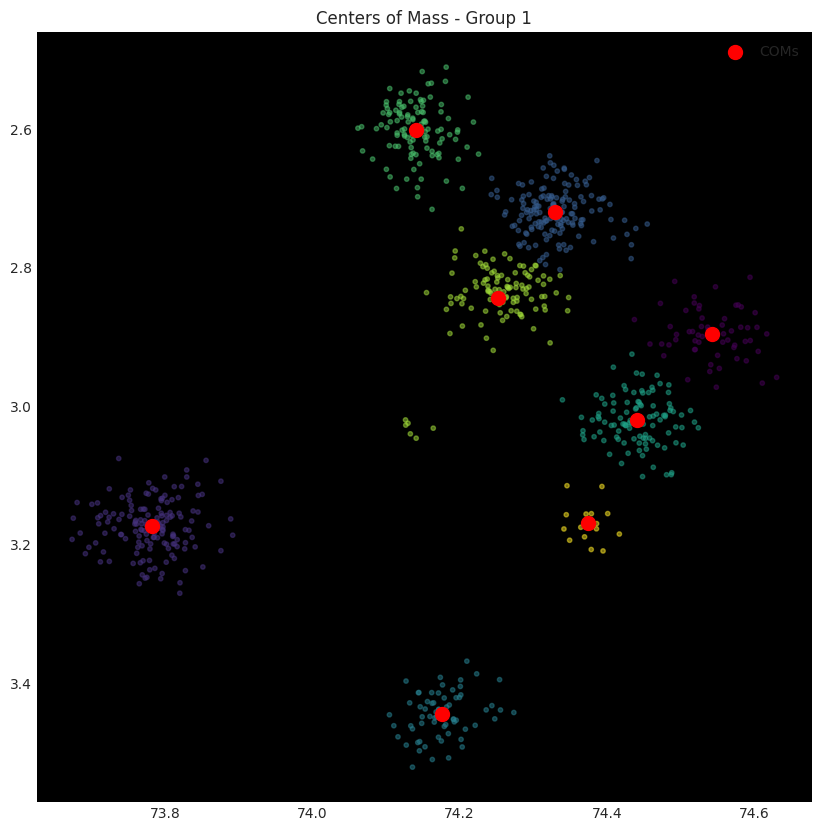

Minimum Bounding Rectangle:
 [[74.56456892  2.86785727]
 [74.14095974  2.60147233]
 [73.77070742  3.19025293]
 [74.1943166   3.45663787]]
Closest side of bounding rectangle:
 3
Closest line start: [74.1943166   3.45663787], end: [74.56456892  2.86785727]
Initial calculated angle: -1.0094361358829187 radians (-57.836430274085515 degrees)
Final rotation angle: 1.0094361358829187 radians (57.836430274085515 degrees)
Rotation angle:
 1.0094361358829187
Rotated Data:
 [[74.84916535  3.03018029]
 [74.94090556  3.01594825]
 [74.51434792  3.4626805 ]
 [74.52332026  3.45097285]
 [74.53924013  3.46637704]]
Rotated Centers of Mass (COM):
 [[74.85465127  3.45354735]
 [74.21360923  2.95623236]
 [74.88976294  3.17909358]
 [74.1943166   3.4353871 ]
 [74.69495173  3.43413195]
 [74.88983754  2.95623236]
 [74.74401876  3.1796653 ]
 [74.53376381  3.45663787]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.151028789472711 radians (237.8364302740855 degrees)


/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


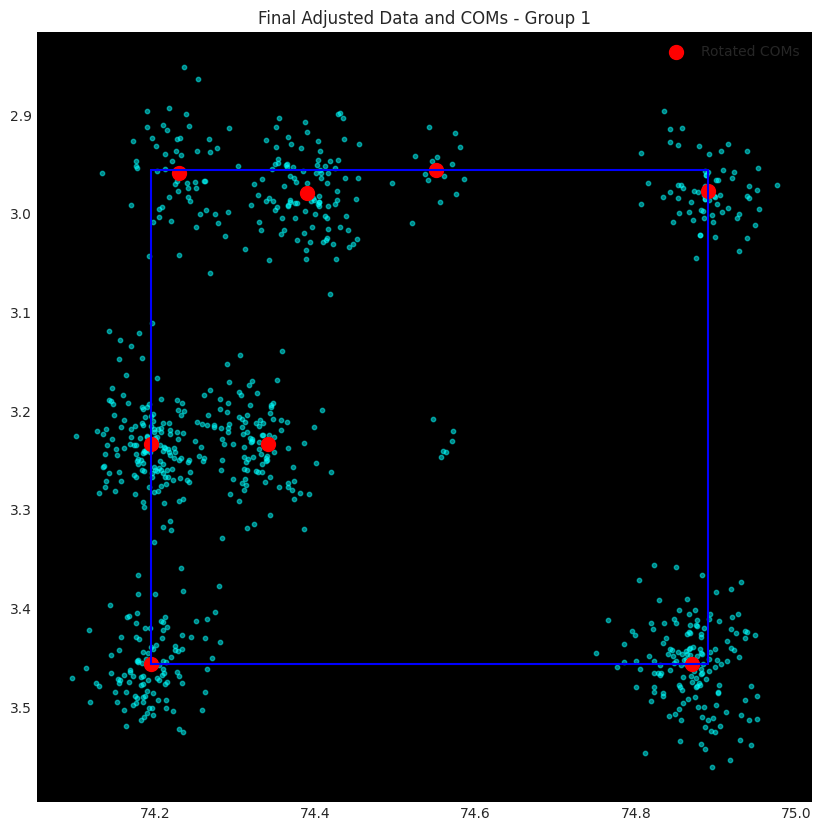

Second Highest COM:
 [74.1943912   3.23377665]
Right Most COM:
 [74.88983754  2.97748313]
Second Right Most COM:
 [74.87054491  3.45663787]
Robot COM:
 [74.34013538  3.23320494]


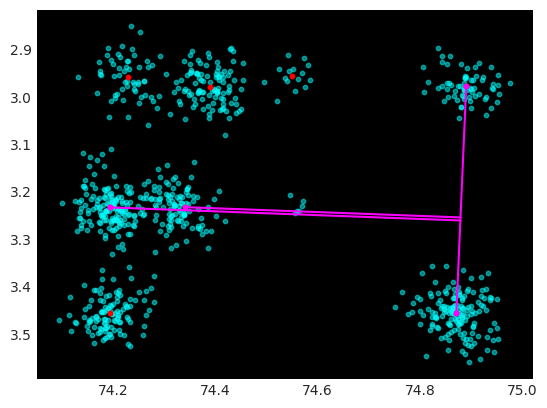

Ratio:
 0.7873077988642899

Processing Group 2
Data collected:
            x          y
0  80.229553  11.981121
1  80.168312  11.962978
2  80.124626  11.972430
3  80.120476  11.994550
4  80.130730  11.978308


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


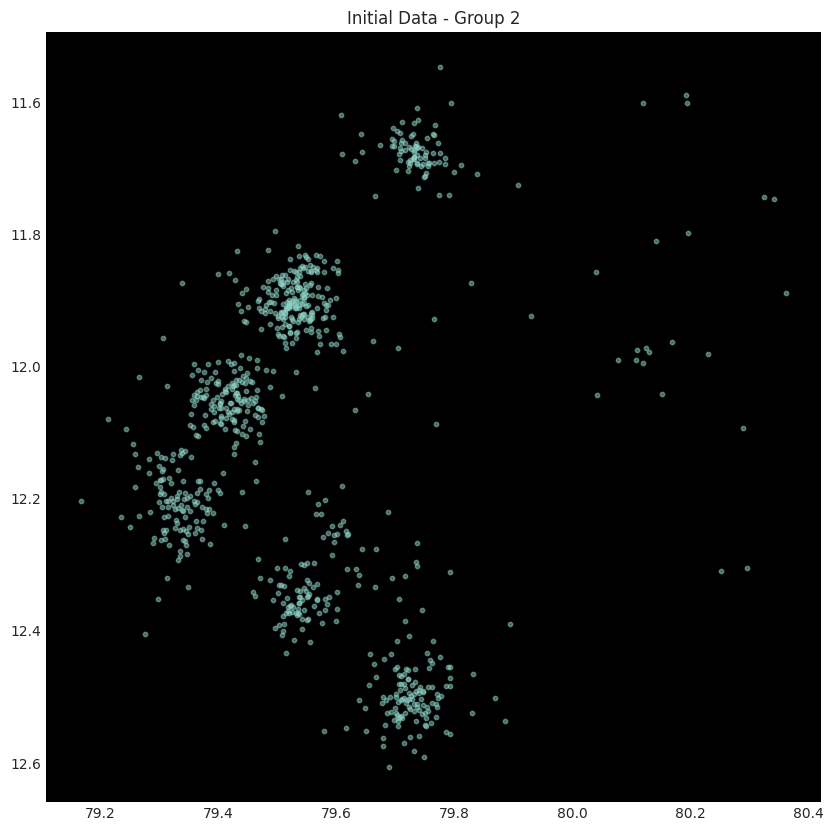

K-Means labels:
 [6 6 6 0 0 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 5 2 0 0 0 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 4 0 0 0 7 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 6 1 1 1 5 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 3 3 3 0 2 2 2 2 2 2 2 2 2 2 4 4 4 4
 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 7 0 2 2 2
 2 2 1 4 4 3 3 3 3 3 3 3 7 1 1 4 2 2 2 2 2 2 4 5 5 3 3 4 4 4 4 1 1 1 2 2 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 1 1 3 3 3 3 3 2 2 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 7 5 3 5 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2
 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4 7 0 0 0 0 0 0 0 0 0
 0 5 5 5 1 1 0 1 1 1 5 5 5 5 5 5 5 5 5 3 4 4 5 5 5 5 4 6 7 4 4 5 5 5 5 1 1
 1 1 5 1 1 3 3 3 3 1 1 0 0 0 0 0 5 5 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0

/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


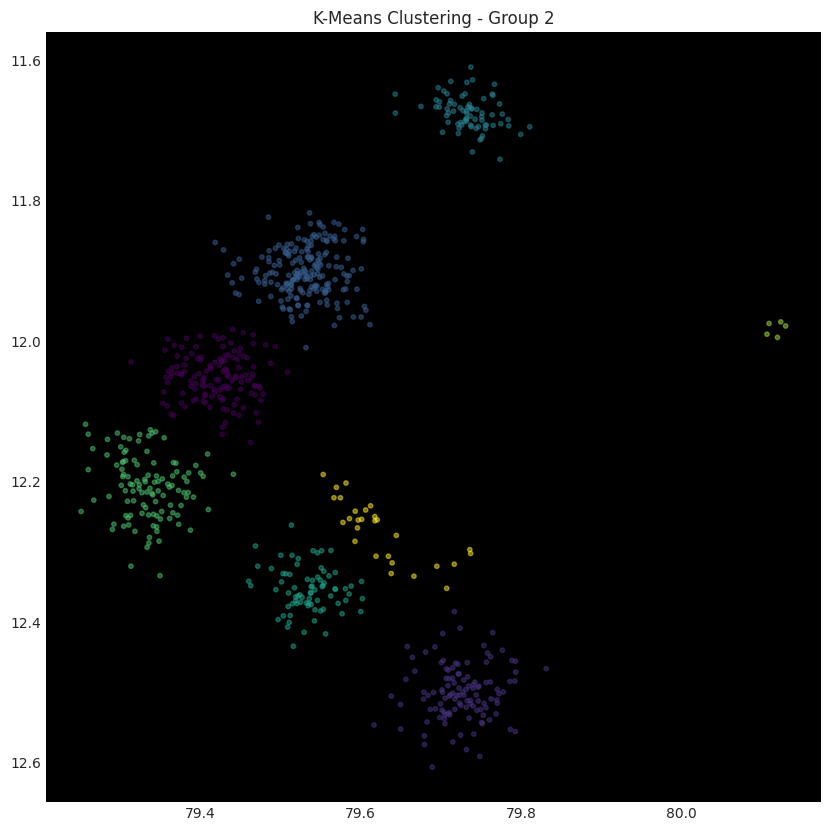

Centers of Mass (COM):
 [(np.float64(79.41932087919137), np.float64(12.051367516065167)), (np.float64(79.72547373278388), np.float64(12.500740380122744)), (np.float64(79.53058730021561), np.float64(11.901049665885397)), (np.float64(79.73416302655194), np.float64(11.675191801947516)), (np.float64(79.53449349654348), np.float64(12.354004257603696)), (np.float64(79.33413301195417), np.float64(12.207533035959516)), (np.float64(80.11865539550782), np.float64(11.981991577148438)), (np.float64(79.62487901960101), np.float64(12.269665036882673))]


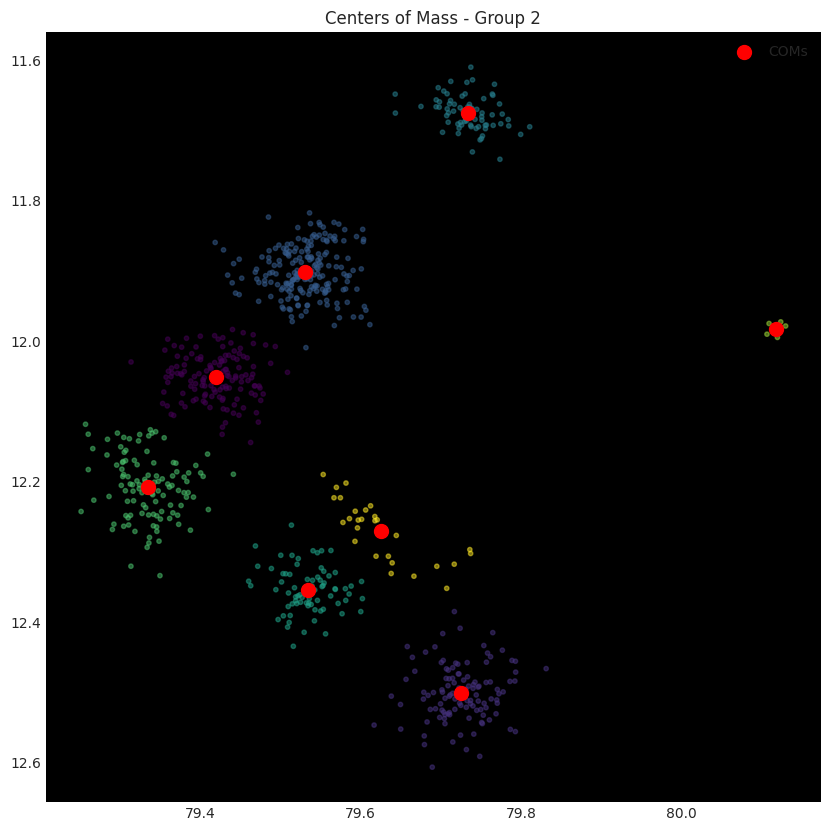

Minimum Bounding Rectangle:
 [[80.12605766 11.97222532]
 [79.71359206 11.6596002 ]
 [79.31136835 12.19027874]
 [79.72383394 12.50290386]]
Closest side of bounding rectangle:
 1
Closest line start: [79.71359206 11.6596002 ], end: [79.31136835 12.19027874]
Initial calculated angle: 2.2193611619830205 radians (127.16002779687733 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.360953815572813 radians (307.1600277968773 degrees)
Final rotation angle: -5.360953815572813 radians (-307.1600277968773 degrees)
Rotation angle:
 -5.360953815572813
Rotated Data:
 [[79.71256408 12.17613732]
 [79.69242887 12.18619081]
 [79.71156679 12.18455179]
 [79.28309136 11.72846194]
 [79.23228144 11.7104239 ]]
Rotated Centers of Mass (COM):
 [[79.22361998 11.66172474]
 [79.05042116 12.17715438]
 [79.41062575 11.6596002 ]
 [79.71359206 11.68541226]
 [79.05200241 11.93631742]
 [79.04770647 11.68816487]
 [79.70133755 12.17715438]
 [79.17381345 11.95740576]]
Final rotation angle after adjustment: -5.3609

/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


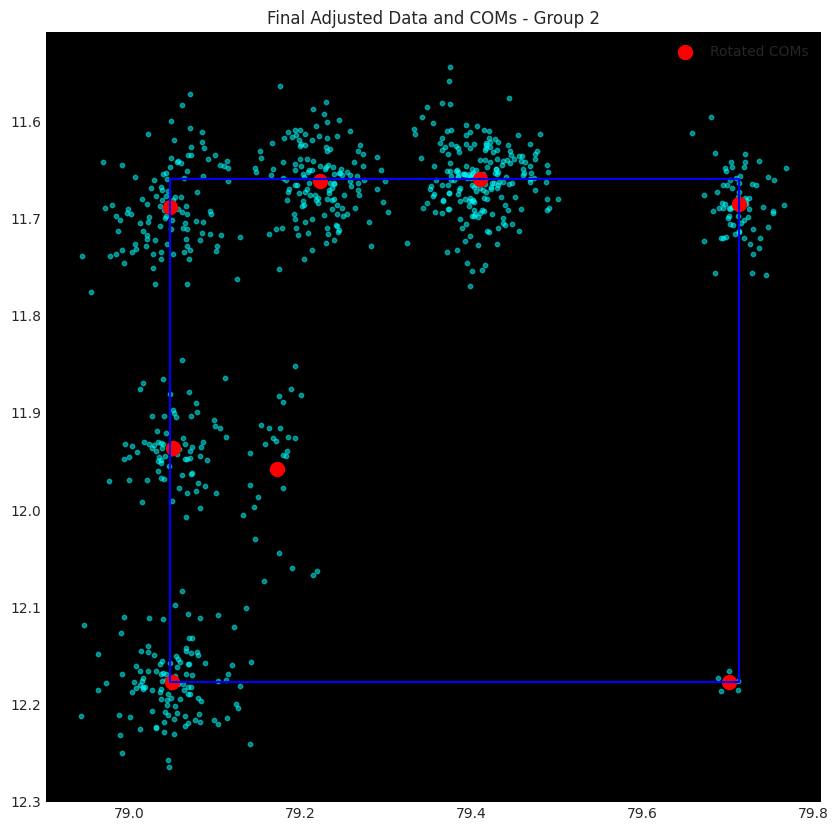

Second Highest COM:
 [79.05200241 11.93631742]
Right Most COM:
 [79.71359206 11.68541226]
Second Right Most COM:
 [79.70133755 12.17715438]
Robot COM:
 [79.17381345 11.95740576]


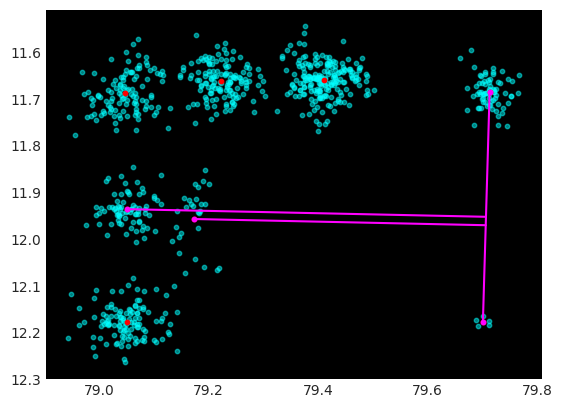

Ratio:
 0.8133226377443719

Processing Group 3
Data collected:
            x         y
0  96.276115  5.262790
1  96.280777  5.182926
2  96.253075  5.196754
3  96.216118  5.205290
4  96.236908  5.174649


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


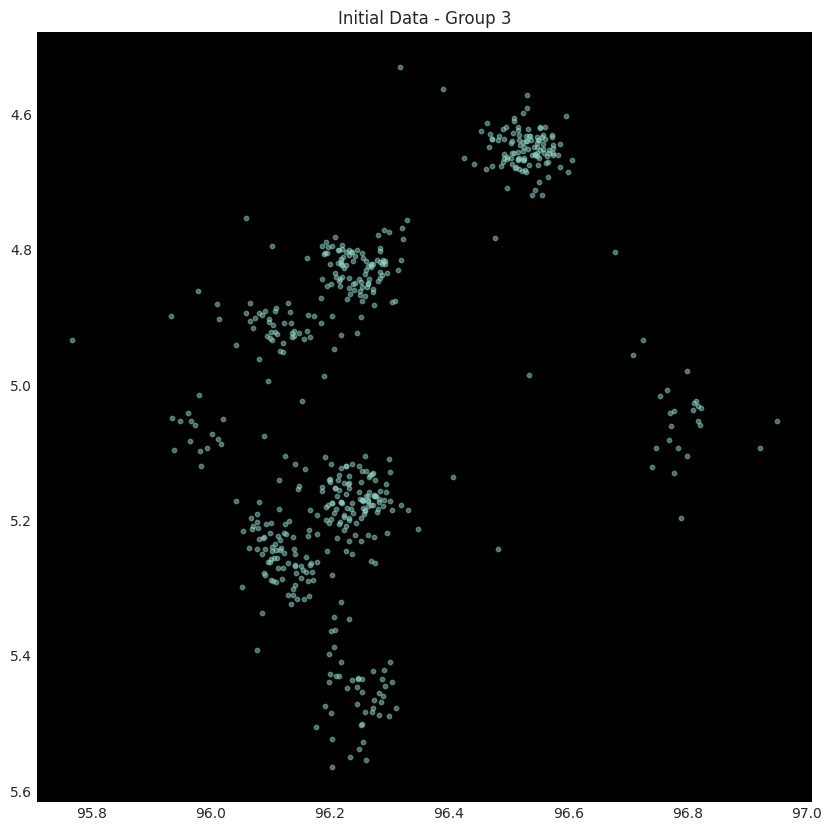

K-Means labels:
 [4 4 4 4 4 3 3 3 3 3 3 3 5 5 5 5 5 5 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 2 2
 2 2 2 2 1 1 1 7 7 7 2 2 2 2 5 5 5 5 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7
 7 7 7 7 7 7 7 4 4 2 2 5 5 5 5 5 5 2 2 6 2 2 2 2 2 1 3 3 3 3 3 3 3 2 2 3 3
 3 3 3 2 2 2 2 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5 5 5 5 4 7
 7 7 6 6 6 6 4 4 7 7 7 7 7 7 7 7 7 7 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 7 4 3 3 3
 3 3 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 4 4 7 7 5 5 5 5 5 1 7 4 4 5 7 7
 7 4 4 1 1 1 1 7 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 4 6 6 6 6 6 6 6 6 6 6 6
 6 6 3 3 3 3 3 6 6 5 5 5 5 5 7 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 2 2 2 2 2 2 2 2 2 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 7 7 4 7 7 4 4 4 6 6 7 7 7 4 4 6 4 4 3 3
 3 3 3 3 3 4 0 3 3 4 4 4 4 4 4 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4
 4 4 4 4 4 4 4 4 7 7 7 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6 0 0 4
 4 4 7 3

/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


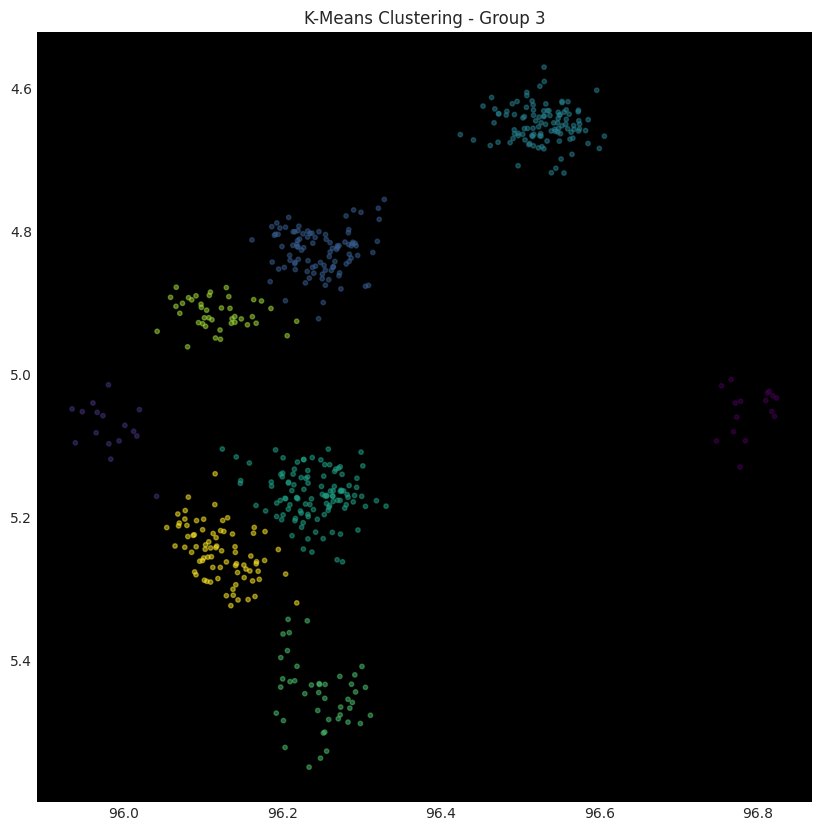

Centers of Mass (COM):
 [(np.float64(96.78995990753174), np.float64(5.0515220165252686)), (np.float64(95.98267555236816), np.float64(5.076121240854263)), (np.float64(96.24738872294523), np.float64(4.828199483910385)), (np.float64(96.5288124434445), np.float64(4.6511377238352365)), (np.float64(96.23948811218801), np.float64(5.169293188415797)), (np.float64(96.24822731905205), np.float64(5.44893665091936)), (np.float64(96.11881479402868), np.float64(4.915374802380073)), (np.float64(96.12314077524039), np.float64(5.250313410392175))]


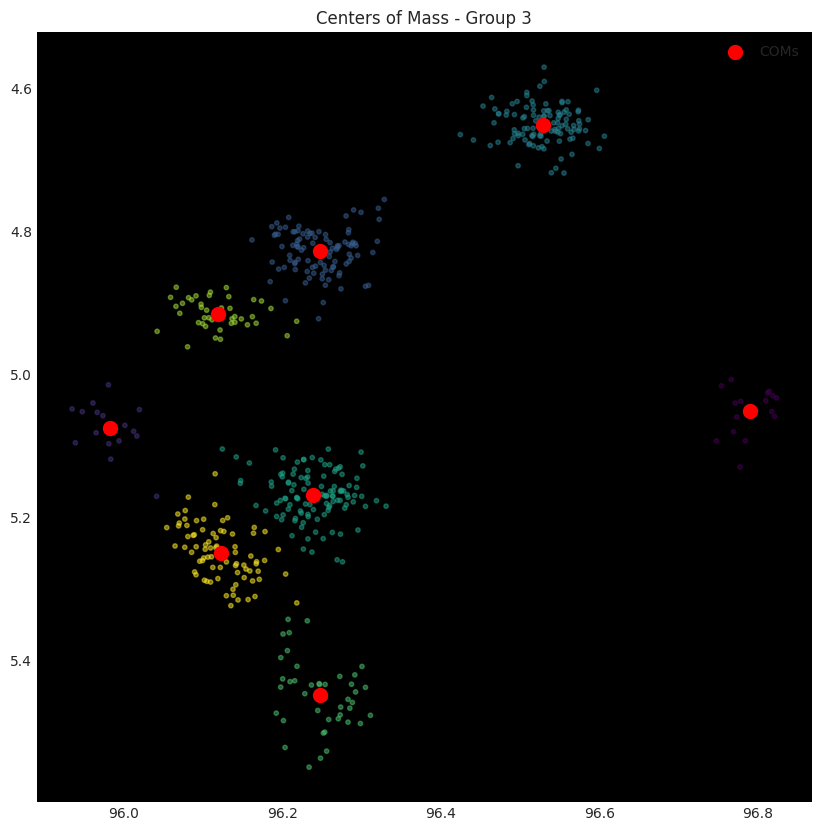

Minimum Bounding Rectangle:
 [[96.81136486  5.04782081]
 [96.51567619  4.63269538]
 [95.95253865  5.03381122]
 [96.24822732  5.44893665]]
Closest side of bounding rectangle:
 1
Closest line start: [96.51567619  4.63269538], end: [95.95253865  5.03381122]
Initial calculated angle: 2.5226675421050015 radians (144.53820327725748 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.664260195694794 radians (324.5382032772575 degrees)
Final rotation angle: -5.664260195694794 radians (-324.5382032772575 degrees)
Rotation angle:
 -5.664260195694794
Rotated Data:
 [[95.95499752  5.00692563]
 [96.00512856  4.94458024]
 [95.97454206  4.93977201]
 [95.93948849  4.92528365]
 [95.97419909  4.91238761]]
Rotated Centers of Mass (COM):
 [[96.49609451  5.13295918]
 [95.82428787  4.68464122]
 [96.18373171  4.63628431]
 [96.51567619  4.65533784]
 [95.97940772  4.90952238]
 [95.82428787  5.14236283]
 [96.02843228  4.63269538]
 [95.83763783  4.90801349]]
Final rotation angle after adjustment: -5.6642

/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


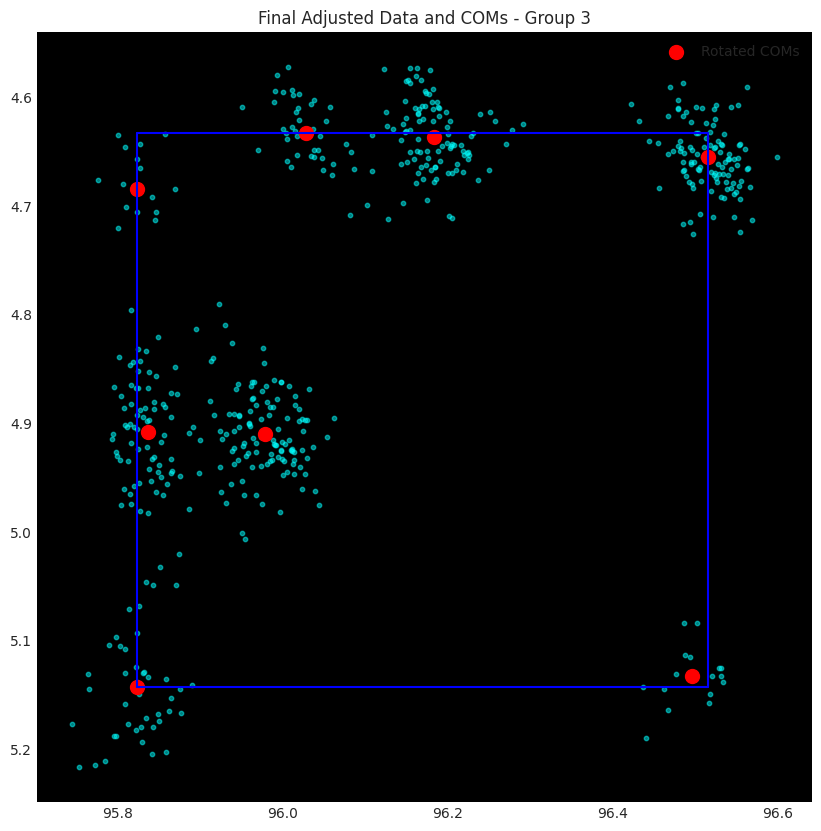

Second Highest COM:
 [95.83763783  4.90801349]
Right Most COM:
 [96.51567619  4.65533784]
Second Right Most COM:
 [96.49609451  5.13295918]
Robot COM:
 [95.97940772  4.90952238]


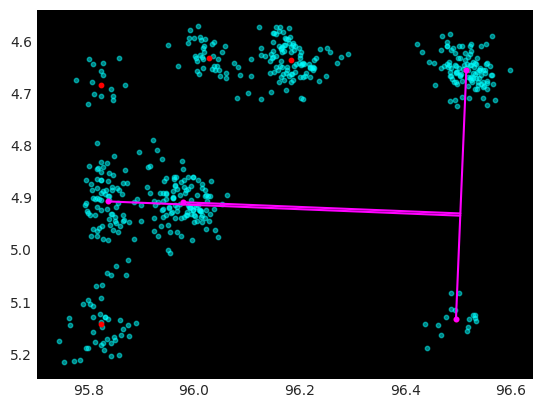

Ratio:
 0.7875749628115616

Processing Group 4
Data collected:
             x          y
0  154.937286  12.149701
1  154.065964  12.067630
2  154.442245  12.426337
3  154.473663  12.418509
4  154.446823  12.387403


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


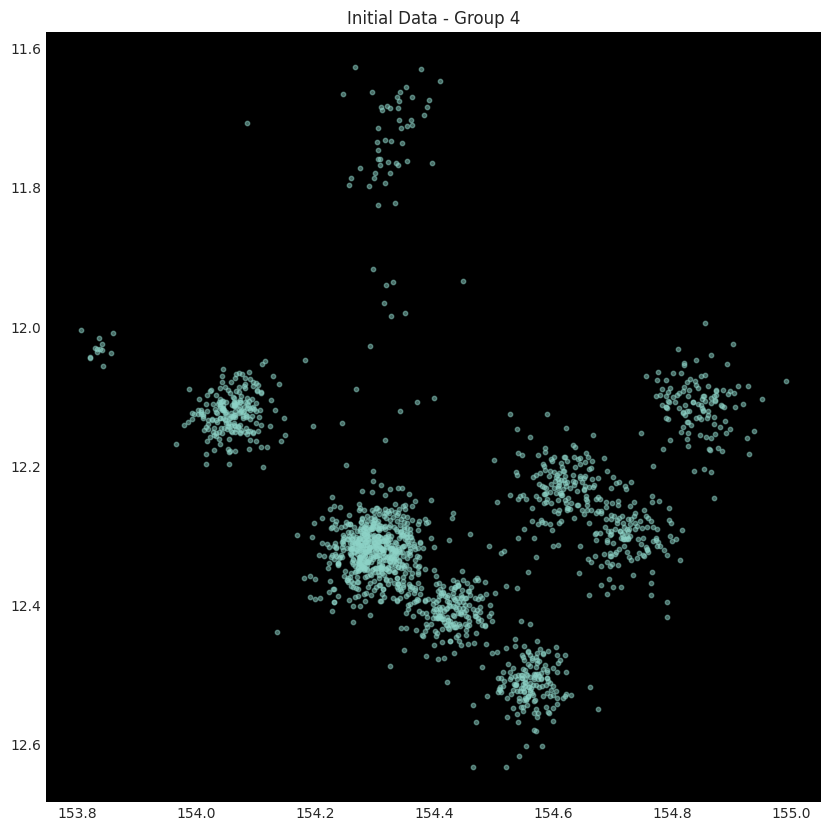

K-Means labels:
 [6 3 5 ... 4 4 4]


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Centers of Mass (COM):
 [(np.float64(154.32709908992686), np.float64(11.747837228977934)), (np.float64(154.2979715485597), np.float64(12.31913875206727)), (np.float64(154.61042541503906), np.float64(12.23017058054606)), (np.float64(154.04831587529816), np.float64(12.118136975617535)), (np.float64(154.72408869646597), np.float64(12.298008255336596)), (np.float64(154.42534669093823), np.float64(12.40108824435467)), (np.float64(154.84213374211237), np.float64(12.114575712089865)), (np.float64(154.5609875190549), np.float64(12.51105708029212))]


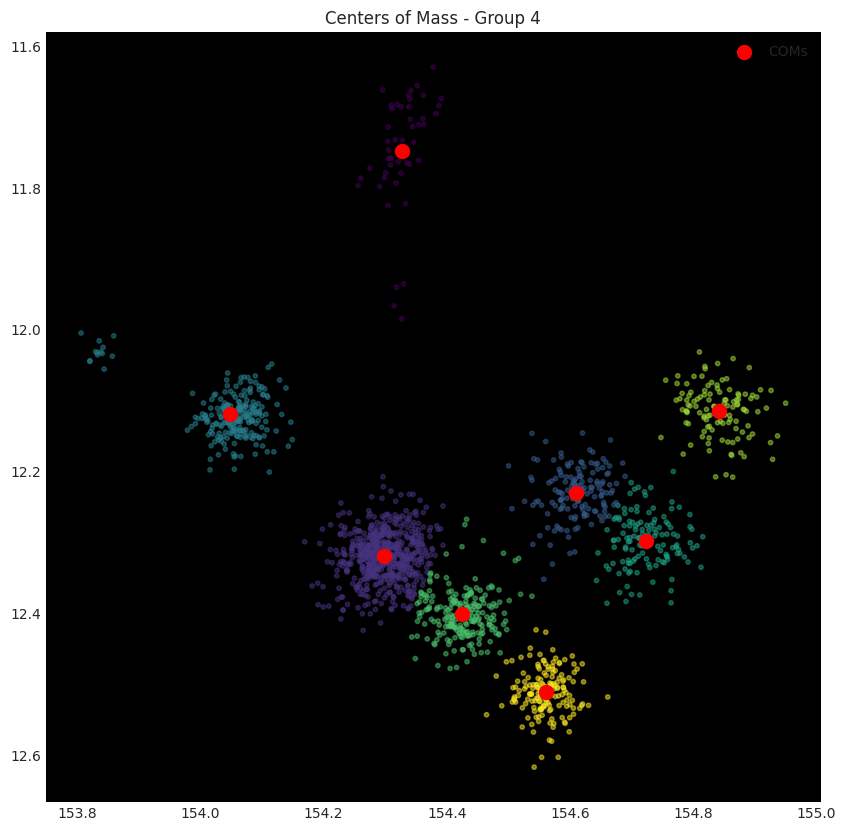

Minimum Bounding Rectangle:
 [[154.85244581  12.12210025]
 [154.32581953  11.73782992]
 [154.03934875  12.13042605]
 [154.56597502  12.51469638]]
Closest side of bounding rectangle:
 2
Closest line start: [154.03934875  12.13042605], end: [154.56597502  12.51469638]
Initial calculated angle: 0.6303710421178288 radians (36.11760024061505 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.7719636957076217 radians (216.11760024061505 degrees)
Final rotation angle: -3.7719636957076217 radians (-216.11760024061505 degrees)
Rotation angle:
 -3.7719636957076217
Rotated Data:
 [[153.30262519  12.64413989]
 [154.05486381  12.19684146]
 [153.53946196  12.12887164]
 [153.51869694  12.15371482]
 [153.55871396  12.1630217 ]]
Rotated Centers of Mass (COM):
 [[154.03241636  12.60909754]
 [153.71919529  12.13042605]
 [153.51923409  12.38646954]
 [154.03934875  12.14563889]
 [153.38742934  12.39866787]
 [153.56799584  12.1393071 ]
 [153.40019481  12.61642731]
 [153.39360345  12.13042605]]
Fina

/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


Second Highest COM:
 [153.38742934  12.39866787]
Right Most COM:
 [154.03934875  12.14563889]
Second Right Most COM:
 [154.03241636  12.60909754]
Robot COM:
 [153.51923409  12.38646954]


Ratio:
 0.7969213706648378

Processing Group 5
Data collected:
             x          y
0  190.320480  16.102219
1  190.276398  16.173414
2  190.258575  16.114859
3  190.139954  16.050495
4  190.059372  16.388666


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


K-Means labels:
 [3 3 3 ... 5 5 5]


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Centers of Mass (COM):
 [(np.float64(190.6016249856115), np.float64(16.469023657389013)), (np.float64(189.92511473681083), np.float64(16.489846298449848)), (np.float64(190.01247227134888), np.float64(16.78321782709879)), (np.float64(190.26333315737614), np.float64(16.141326526263814)), (np.float64(190.06409335355147), np.float64(16.3910066797099)), (np.float64(190.15159020057092), np.float64(16.965256057419143)), (np.float64(190.13467536782318), np.float64(16.674321660455668)), (np.float64(189.81031627165964), np.float64(16.619736236181016))]


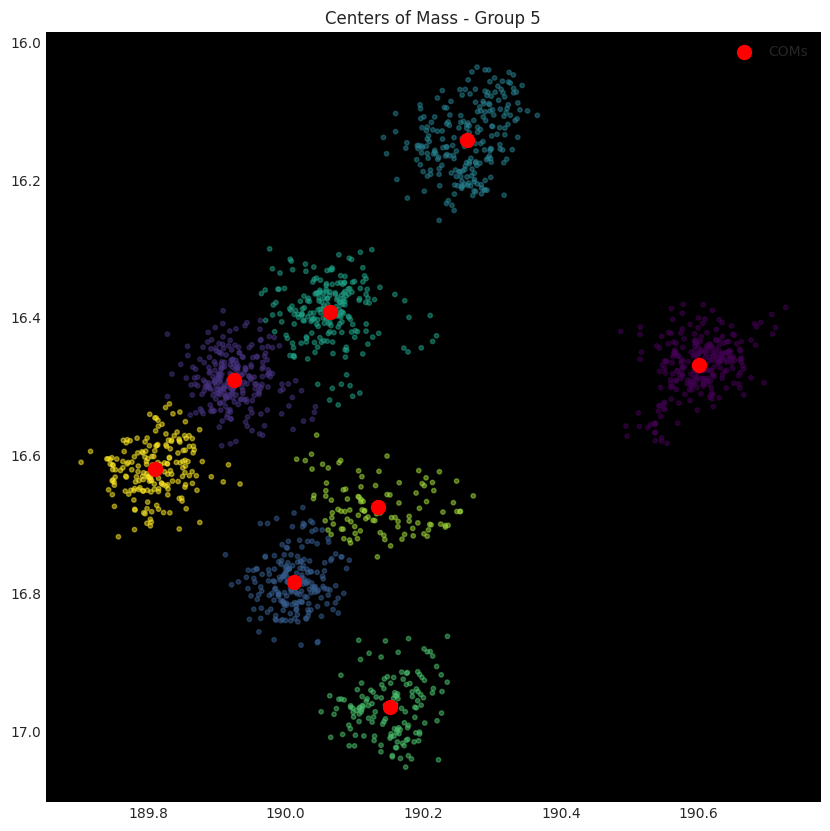

Minimum Bounding Rectangle:
 [[190.6174408   16.48434415]
 [190.26301656  16.14101985]
 [189.79716596  16.62193175]
 [190.1515902   16.96525606]]
Closest side of bounding rectangle:
 1
Closest line start: [190.26301656  16.14101985], end: [189.79716596  16.62193175]
Initial calculated angle: 2.340287614622239 radians (134.08860316459317 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.4818802682120324 radians (314.0886031645932 degrees)
Final rotation angle: -5.4818802682120324 radians (-314.0886031645932 degrees)
Rotation angle:
 -5.4818802682120324
Rotated Data:
 [[190.33086768  16.15529733]
 [190.24905902  16.17317009]
 [190.27871724  16.11962775]
 [189.94345116  16.16705396]
 [190.00621532  16.18876702]]
Rotated Centers of Mass (COM):
 [[190.26301656  16.61244552]
 [189.7773649   16.14101985]
 [189.62742723  16.40788477]
 [190.26301656  16.14146062]
 [189.94505506  16.17207365]
 [189.59346967  16.634465  ]
 [189.79066875  16.41989227]
 [189.60419622  16.14893768]]
Final 

/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


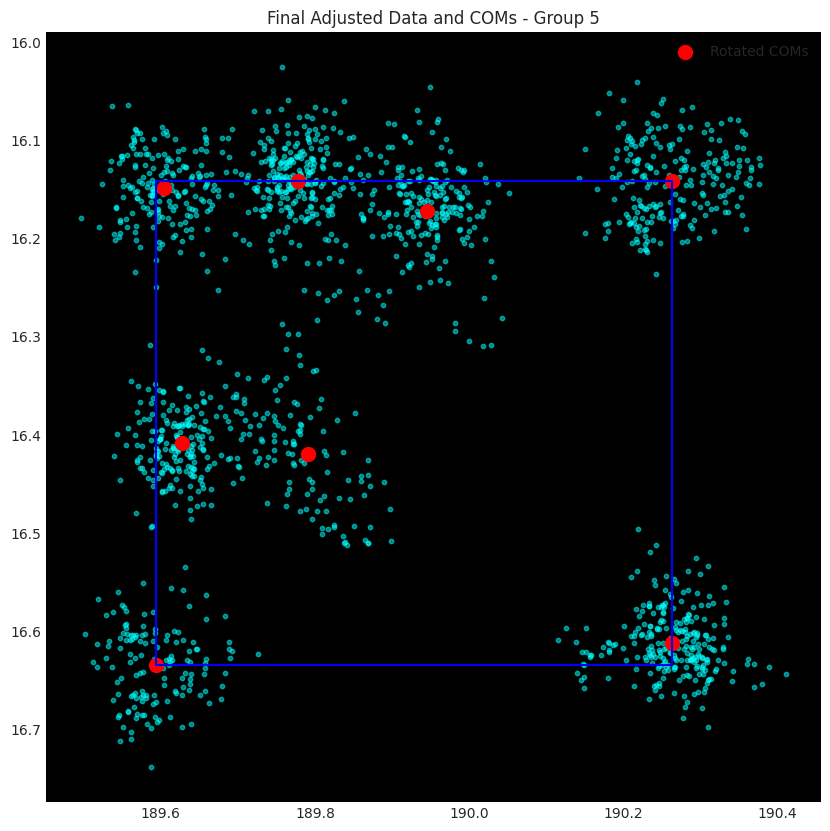

Second Highest COM:
 [189.62742723  16.40788477]
Right Most COM:
 [190.26301656  16.61244552]
Second Right Most COM:
 [190.26301656  16.14146062]
Robot COM:
 [189.79066875  16.41989227]


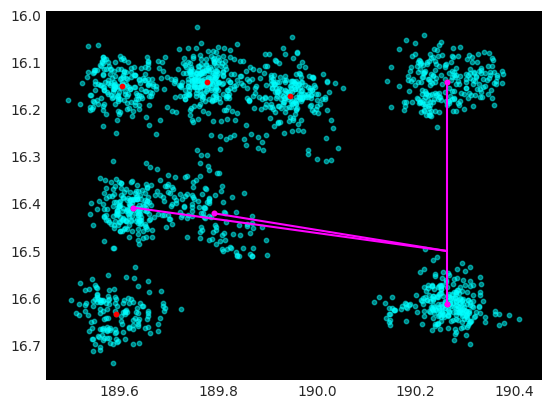

Ratio:
 0.743165112697745

Processing Group 6
Data collected:
             x         y
0  192.853226  3.511629
1  192.808411  3.494667
2  192.990067  3.477808
3  192.797516  3.549601
4  192.846237  3.472739


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


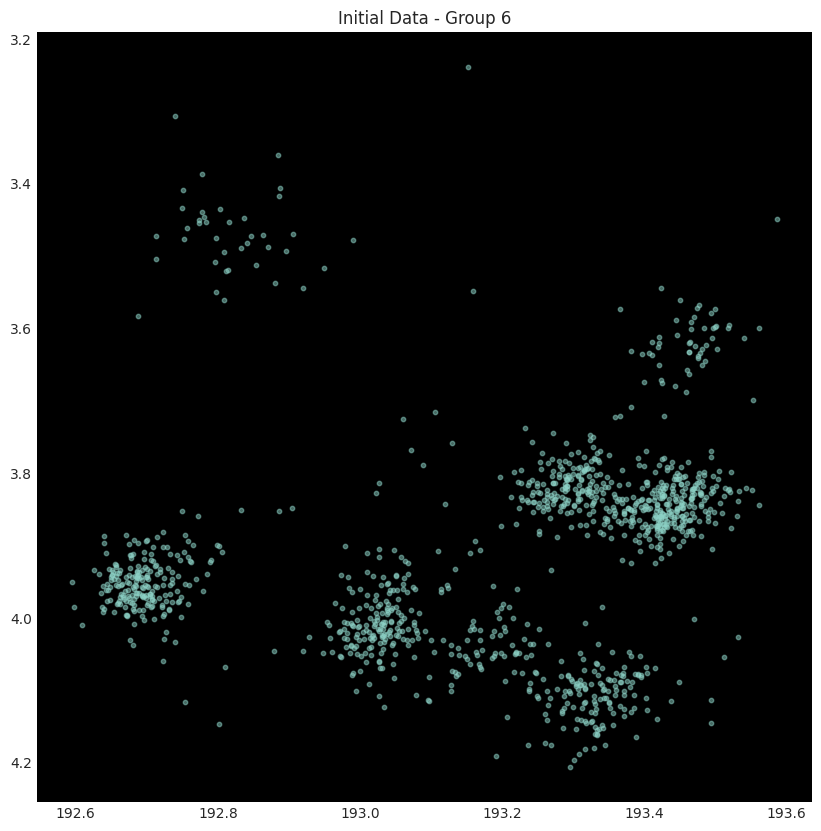

K-Means labels:
 [4 4 4 ... 1 1 6]


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Centers of Mass (COM):
 [(np.float64(193.02428147483008), np.float64(4.007304190242358)), (np.float64(193.29721959431967), np.float64(3.820880694935719)), (np.float64(192.69556160520708), np.float64(3.9520372705596487)), (np.float64(193.33216493521164), np.float64(4.108873289022872)), (np.float64(192.80719177246092), np.float64(3.4731834030151365)), (np.float64(193.45892116001673), np.float64(3.6255633587739906)), (np.float64(193.43862898271163), np.float64(3.8451310321961567)), (np.float64(193.17912195905853), np.float64(4.034265463865256))]


Minimum Bounding Rectangle:
 [[193.48835666   3.63244563]
 [192.80719177   3.4731834 ]
 [192.69347682   3.9595425 ]
 [193.37464171   4.11880473]]
Closest side of bounding rectangle:
 2
Closest line start: [192.69347682   3.9595425 ], end: [193.37464171   4.11880473]
Initial calculated angle: 0.22968264213669157 radians (13.159846021846072 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.371275295726485 radians (193.15984602184608 degrees)
Final rotation angle: -3.371275295726485 radians (-193.15984602184608 degrees)
Rotation angle:
 -3.371275295726485
Rotated Data:
 [[192.63989886   4.43206266]
 [192.68739881   4.43837651]
 [192.68550072   4.38240473]
 [192.65555803   4.46834087]
 [192.65870487   4.457605  ]]
Rotated Centers of Mass (COM):
 [[192.36048569   3.98834889]
 [192.13715804   4.23201607]
 [192.69315549   3.96732526]
 [192.03756357   3.9595425 ]
 [192.69347682   4.45901848]
 [192.02417058   4.45901848]
 [191.99394121   4.24059705]
 [192.20357329   3.99734795]]
Final

/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


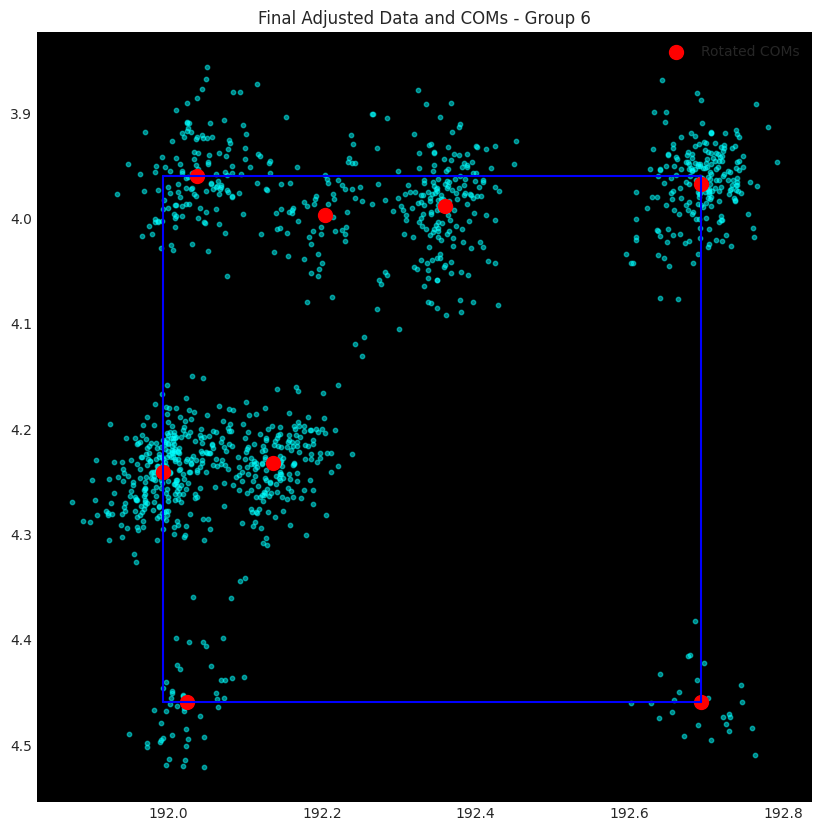

Second Highest COM:
 [191.99394121   4.24059705]
Right Most COM:
 [192.69347682   4.45901848]
Second Right Most COM:
 [192.69315549   3.96732526]
Robot COM:
 [192.13715804   4.23201607]


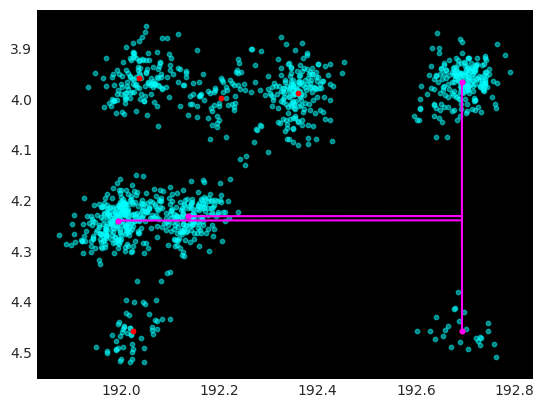

Ratio:
 0.7952189009981228

Processing Group 7
Data collected:
             x          y
0  223.384872  14.570362
1  223.379608  14.605626
2  223.415466  14.562952
3  223.395050  14.599780
4  223.444214  14.630434


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


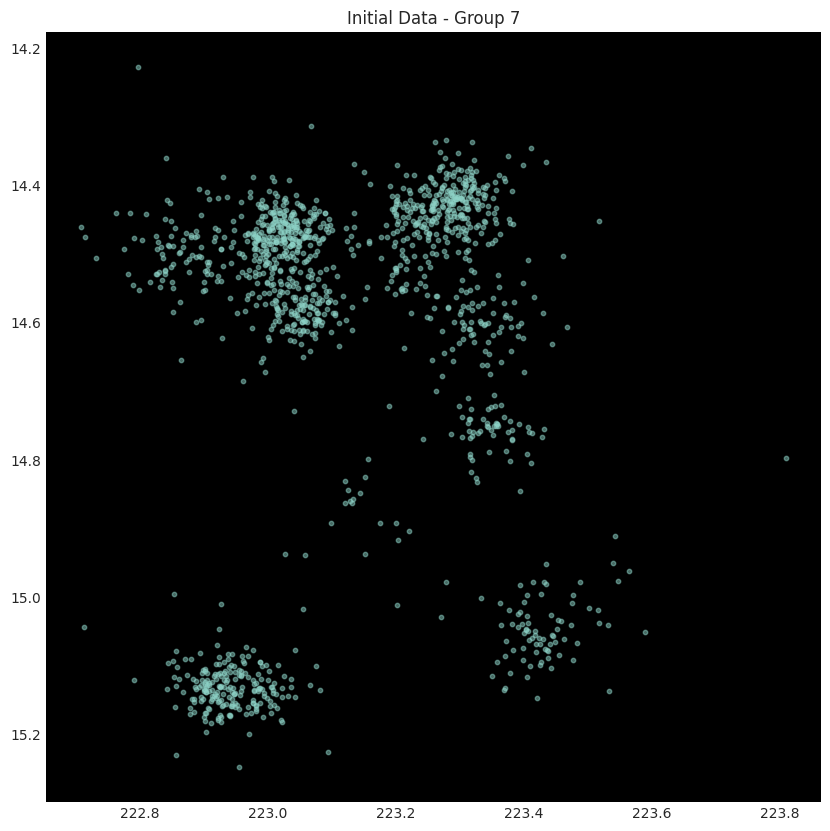

K-Means labels:
 [7 7 7 ... 2 2 1]


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


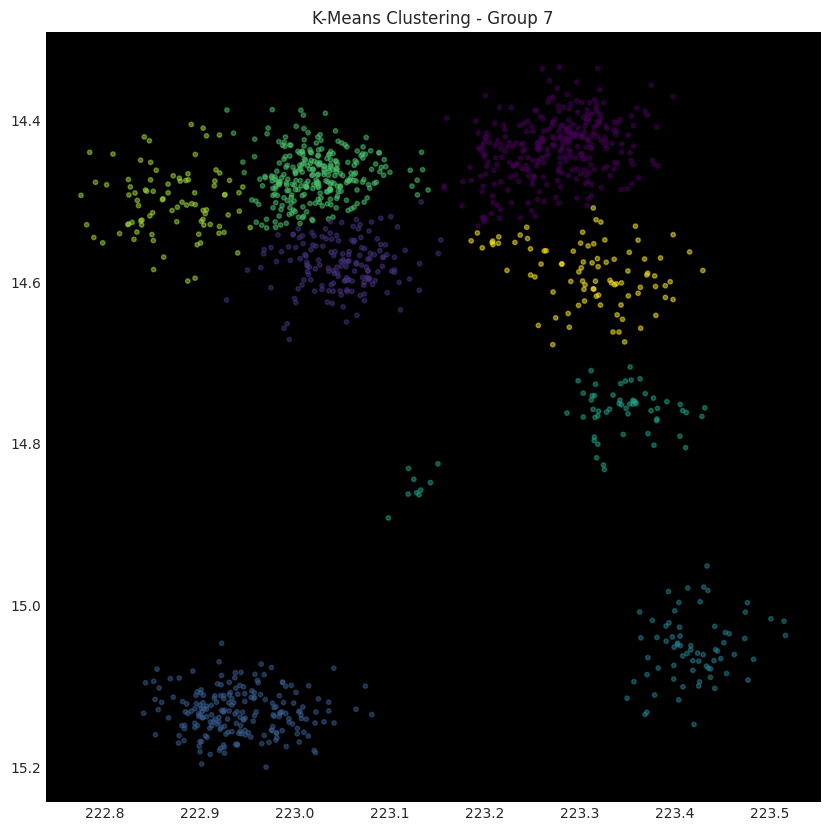

Centers of Mass (COM):
 [(np.float64(223.2744686971575), np.float64(14.43474318677147)), (np.float64(223.04884252548217), np.float64(14.577999711036682)), (np.float64(222.9419002906949), np.float64(15.132546275269751)), (np.float64(223.42048777704653), np.float64(15.053818260414014)), (np.float64(223.31831073760986), np.float64(14.772272646427155)), (np.float64(223.02284609616459), np.float64(14.469206279014056)), (np.float64(222.87144504504258), np.float64(14.50094046217672)), (np.float64(223.31052184372805), np.float64(14.588921911261055))]


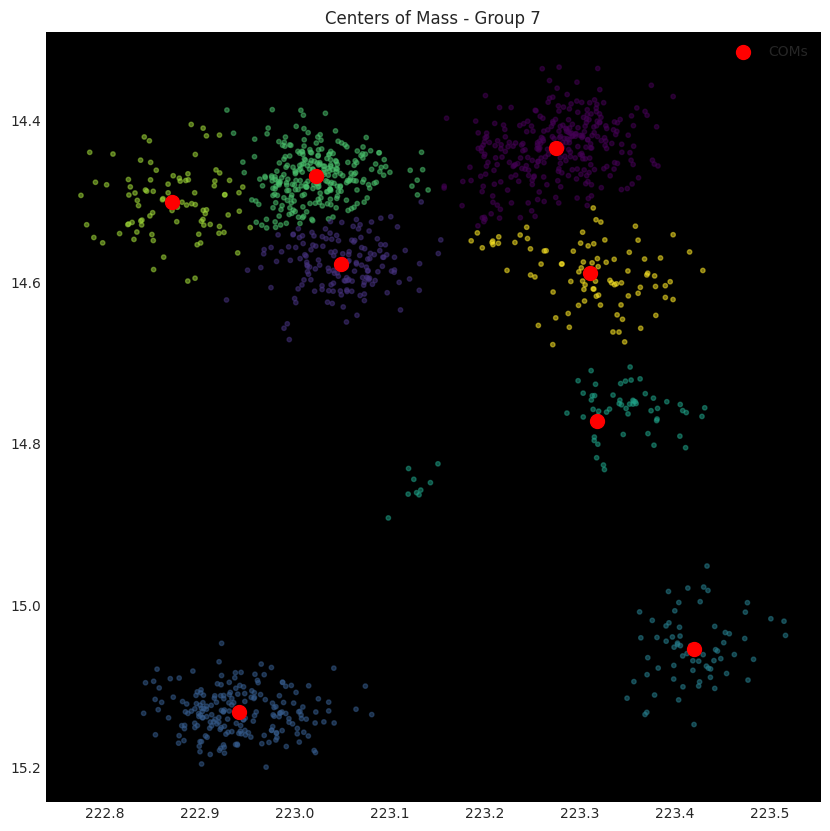

Minimum Bounding Rectangle:
 [[223.42225959  15.06675462]
 [223.3345697   14.42651155]
 [222.85421041  14.4923032 ]
 [222.94190029  15.13254628]]
Closest side of bounding rectangle:
 0
Closest line start: [223.42225959  15.06675462], end: [223.3345697   14.42651155]
Initial calculated angle: -1.706912828694078 radians (-97.79890108090756 degrees)
Final rotation angle: 1.706912828694078 radians (97.79890108090756 degrees)
Rotation angle:
 1.706912828694078
Rotated Data:
 [[223.91913401  15.09707205]
 [223.88491052  15.08707126]
 [223.92232404  15.12838846]
 [223.88860706  15.10316361]
 [224.0840142   14.80372889]]
Rotated Centers of Mass (COM):
 [[224.06847991  15.00609252]
 [223.95716515  14.76311387]
 [223.42225959  14.58191074]
 [223.43531672  15.06675462]
 [223.72812324  15.00372745]
 [224.06847991  14.75212079]
 [224.05758386  14.59781391]
 [223.91083498  15.02089067]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.848505482283871 radians (277.7989010809075 degre

/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


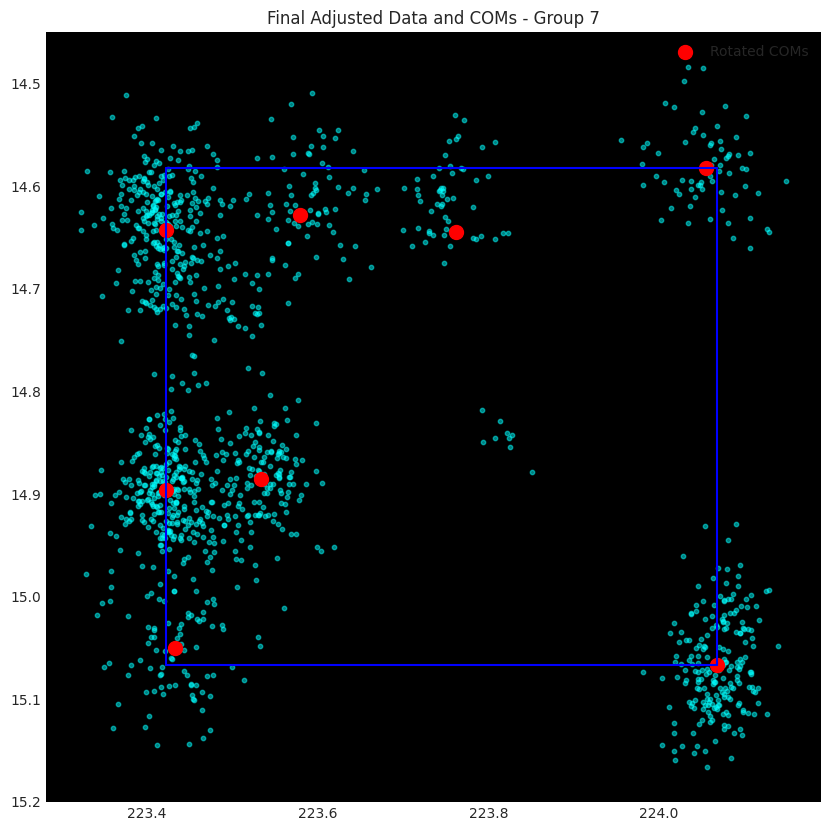

Second Highest COM:
 [223.42225959  14.89654457]
Right Most COM:
 [224.06847991  15.06675462]
Second Right Most COM:
 [224.05542278  14.58191074]
Robot COM:
 [223.53357435  14.88555149]


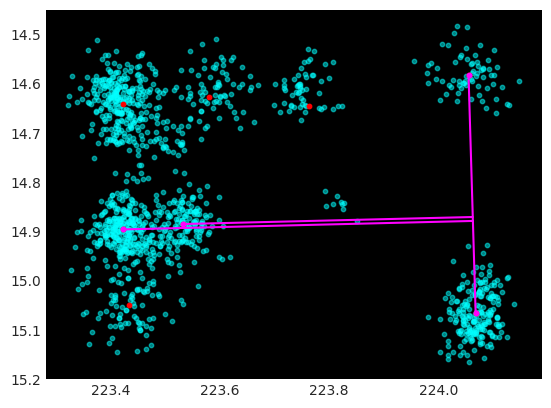

Ratio:
 0.8260528774731372

Processing Group 8
Data collected:
             x         y
0  237.977173  6.251901
1  238.027069  6.185611
2  238.016663  6.100646
3  238.483246  5.802577
4  238.440857  5.771270


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


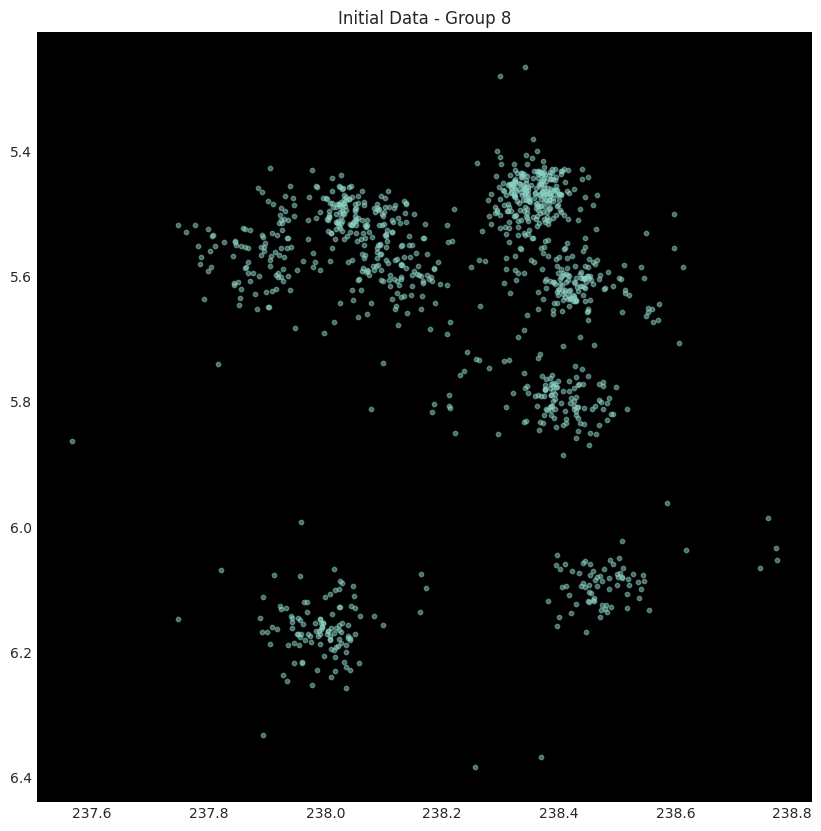

K-Means labels:
 [1 1 1 ... 0 0 0]


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Centers of Mass (COM):
 [(np.float64(238.12272824374114), np.float64(5.585395297137174)), (np.float64(237.99131246713492), np.float64(6.166621813407311)), (np.float64(238.39081909696935), np.float64(5.793272184113325)), (np.float64(238.35515164572095), np.float64(5.472246902329581)), (np.float64(238.46940904505112), np.float64(6.094479750184452)), (np.float64(238.4290311556336), np.float64(5.6123571497328735)), (np.float64(237.8844817086552), np.float64(5.561527053961593)), (np.float64(238.04020298228545), np.float64(5.5001086277120255))]


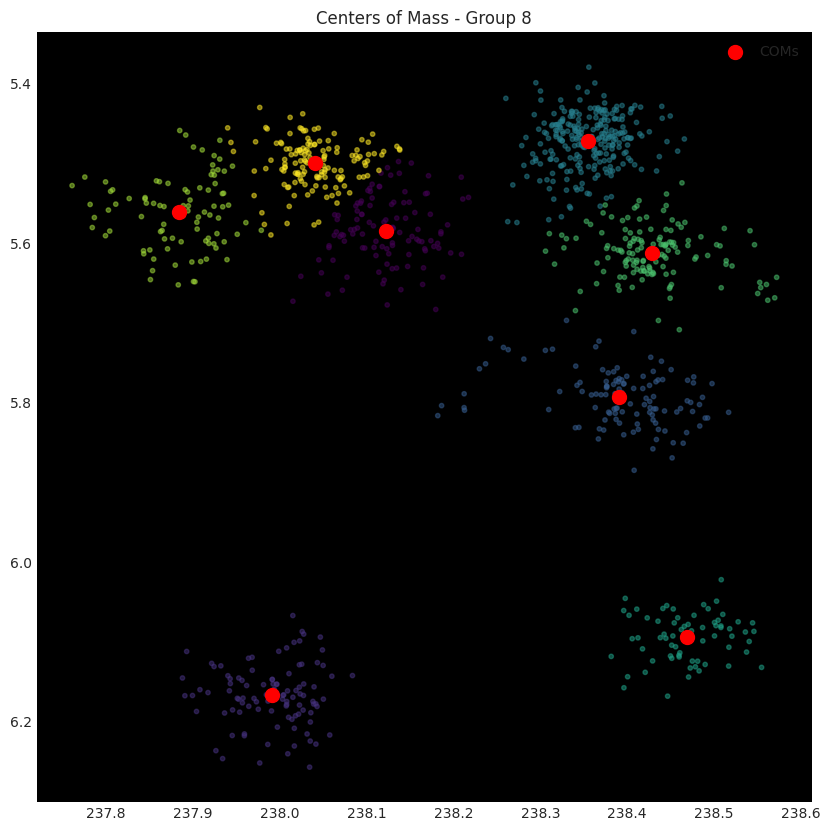

Minimum Bounding Rectangle:
 [[238.51279844   6.08681926]
 [238.39805884   5.43692842]
 [237.87867315   5.52862706]
 [237.99341275   6.1785179 ]]
Closest side of bounding rectangle:
 0
Closest line start: [238.51279844   6.08681926], end: [238.39805884   5.43692842]
Initial calculated angle: -1.7455475875225994 radians (-100.01250970428762 degrees)
Final rotation angle: 1.7455475875225994 radians (100.01250970428762 degrees)
Rotation angle:
 1.7455475875225994
Rotated Data:
 [[238.44335683   5.53064976]
 [238.499962     5.59131145]
 [238.5854425    5.59583577]
 [238.79784926   6.10713594]
 [238.83604954   6.07083579]]
Rotated Centers of Mass (COM):
 [[239.07440448   5.78986907]
 [238.52487851   5.55940088]
 [238.82308246   6.01773471]
 [239.14541973   6.03842496]
 [238.51279844   6.04275881]
 [238.99459846   6.08681926]
 [239.13933151   5.55940088]
 [239.17274032   5.7234289 ]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.887140241112393 radians (280.01250970428765

/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


Second Highest COM:
 [238.51279844   5.92279125]
Right Most COM:
 [239.17274032   5.60346133]
Second Right Most COM:
 [239.16066025   6.08681926]
Robot COM:
 [238.61113429   5.85635107]


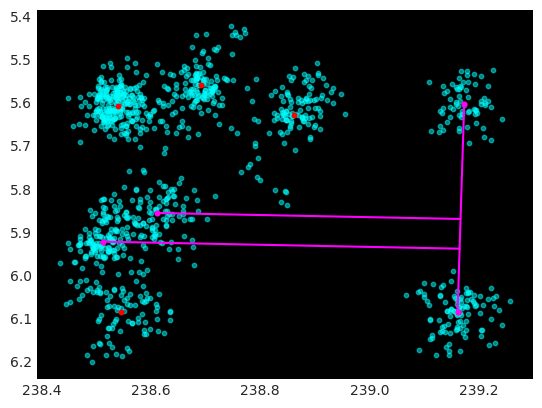

Ratio:
 0.8517160635799669

Processing Group 9
Data collected:
             x          y
0  204.727203  23.444227
1  204.673523  23.472221
2  204.732361  23.457150
3  204.768372  23.501686
4  205.214050  22.981375


/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


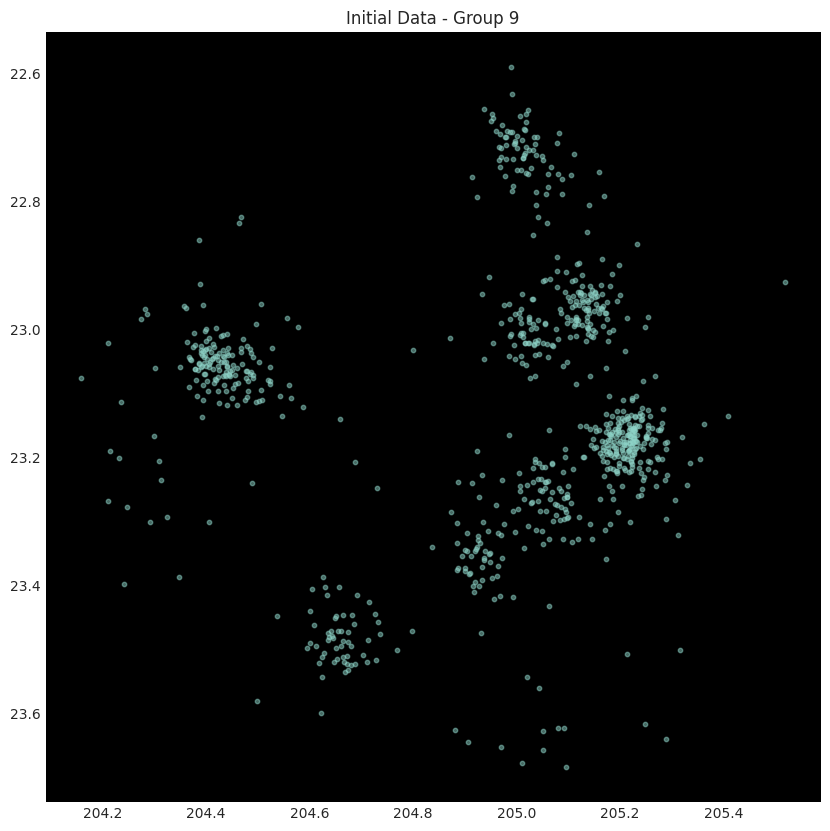

K-Means labels:
 [5 5 5 0 0 0 4 4 4 4 4 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 7 7 2 5 5 5 2 2 2 2 2 2 1 1 1 1 1 1 0 0
 7 2 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 6 6 6 3 3 3 3 3 1 1 1 1 1 1 3 3 3 3
 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 0 0 0 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 1 7 4 4 4 4 4 4 4 4 4 4 4 7 7 7 0 0 0 0 0 0 0 7 7 4 4 5 0 0
 3 3 1 1 1 1 1 1 1 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 0 5 5 5 5 1 1 1 1 1 1 1 4 4 4 5 5 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 5 5 4 4 4 4 4 6 6 6 6 7 7 3 6 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1
 1 1 1 1 3 6 6 6 6 6 6 6 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 4 4 4 4 0 0 6 6 6 7 7 1 1 1 1 1 1 1 2 6 2 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 4 4 4 4 4 4 4 4 4 4 4 4 3 3 6 2 2 2 2 2 3
 7 7 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 4 4 4 5 5 5 5 5
 5 5 5 5

/tmp/ipykernel_3080/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


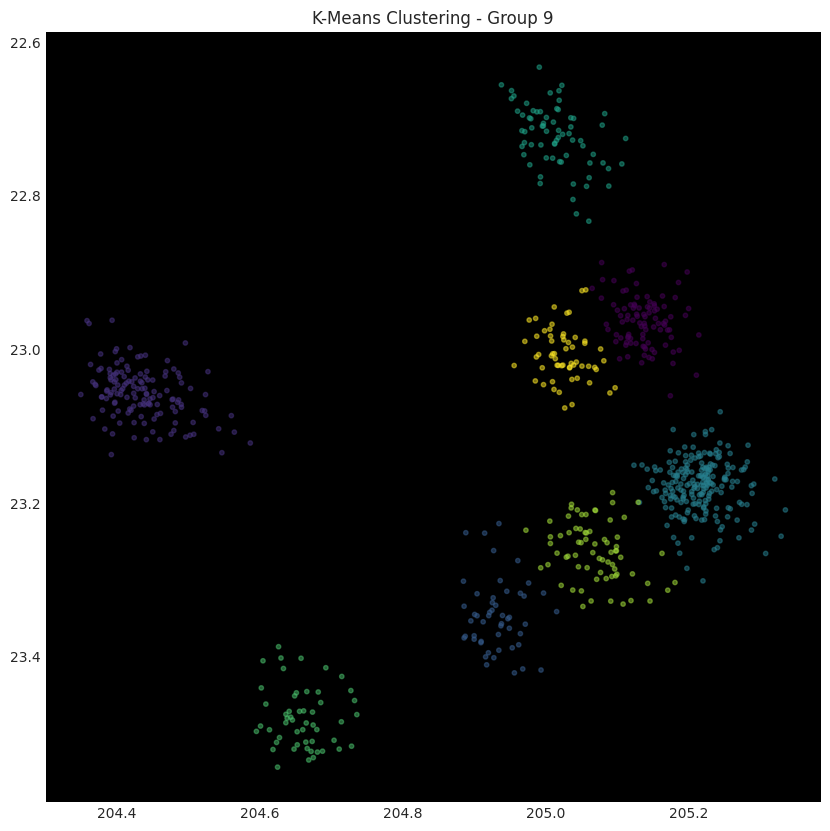

Centers of Mass (COM):
 [(np.float64(205.13715547260486), np.float64(22.963913385491622)), (np.float64(204.43534316459713), np.float64(23.057745411448234)), (np.float64(204.9325094604492), np.float64(23.34688194274902)), (np.float64(205.21591496017743), np.float64(23.178416189157737)), (np.float64(205.01420018292856), np.float64(22.723217590995457)), (np.float64(204.65958844698392), np.float64(23.47965438549335)), (np.float64(205.06986454554968), np.float64(23.263081741333007)), (np.float64(205.02587311843345), np.float64(23.006687262962604))]


Minimum Bounding Rectangle:
 [[205.26393334  23.15534845]
 [205.01420018  22.72321759]
 [204.42066489  23.06622815]
 [204.67039805  23.498359  ]]
Closest side of bounding rectangle:
 3
Closest line start: [204.67039805  23.498359  ], end: [205.26393334  23.15534845]
Initial calculated angle: -0.5240191984557783 radians (-30.0240884553444 degrees)
Final rotation angle: 0.5240191984557783 radians (30.0240884553444 degrees)
Rotation angle:
 0.5240191984557783
Rotated Data:
 [[204.74666655  23.47991423]
 [204.68618196  23.47729224]
 [204.74466612  23.49368315]
 [205.39978072  23.32277025]
 [205.39630109  23.29131249]]
Rotated Centers of Mass (COM):
 [[205.34194106  23.26917654]
 [204.68735118  22.99925608]
 [204.97313175  23.498359  ]
 [205.30280272  23.49430473]
 [205.35592003  22.99925608]
 [204.67039805  23.47675553]
 [205.13398646  23.49453107]
 [205.2241886   23.25052912]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 3.665611852045571 radians (210.02408845534438 deg

/tmp/ipykernel_3080/2238193426.py:121: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


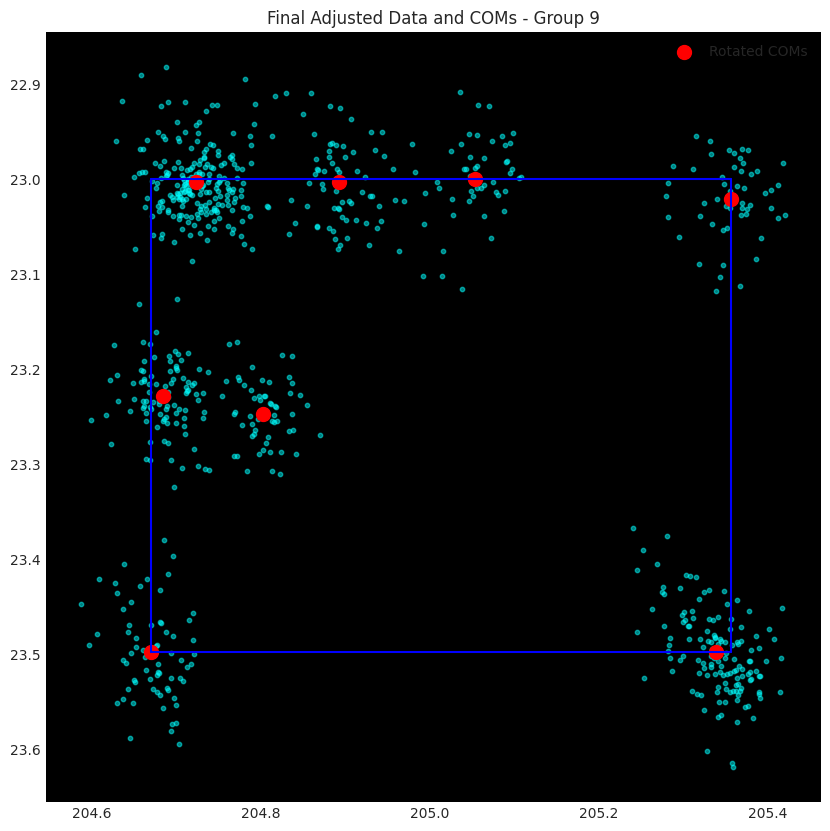

Second Highest COM:
 [204.68437702  23.22843854]
Right Most COM:
 [205.35592003  23.02085956]
Second Right Most COM:
 [205.3389669  23.498359 ]
Robot COM:
 [204.80212948  23.24708596]


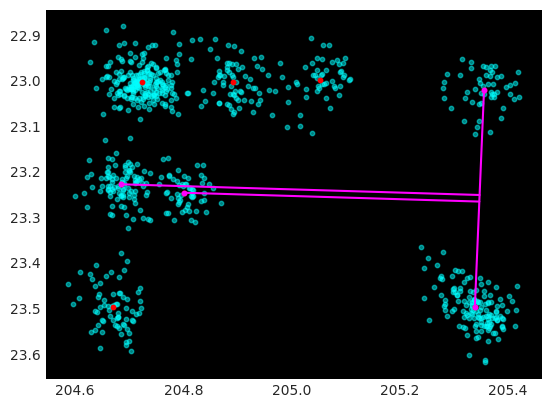

Ratio:
 0.8217113765333516


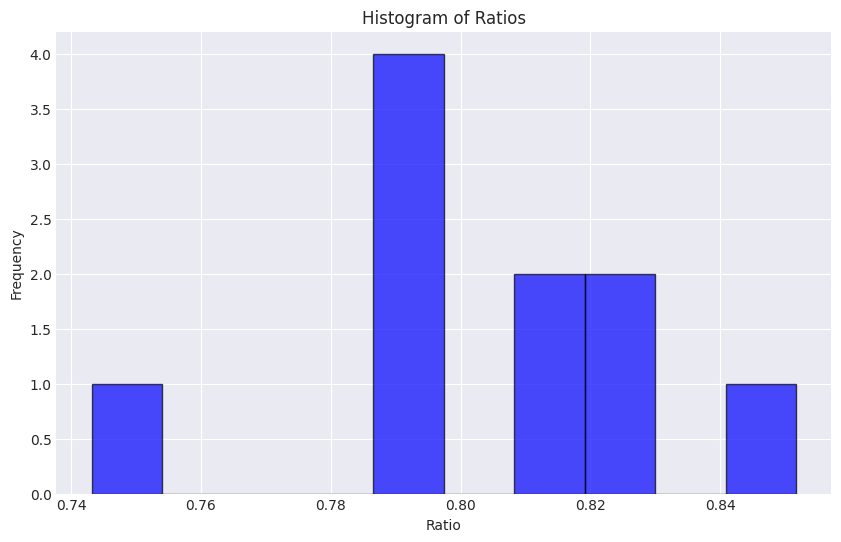

Mean Ratio: 0.8034623317807468
Standard Deviation: 0.027560163369798697


[np.float64(0.8116322164400822),
 np.float64(0.7873077988642899),
 np.float64(0.8133226377443719),
 np.float64(0.7875749628115616),
 np.float64(0.7969213706648378),
 np.float64(0.743165112697745),
 np.float64(0.7952189009981228),
 np.float64(0.8260528774731372),
 np.float64(0.8517160635799669),
 np.float64(0.8217113765333516)]

In [50]:
# Example usage
filename = 'data/n=10_origmi_locs.hdf5'
k = 8
process_multiple_origami_ratio(filename, k)

In [ ]:
ratio = process_origami_ratio('data/csDNA_v8_1nM_20nm_0.5nM_TT1_3_to_5_pos_ctrl_rayhan_8724_T2_cropped_locs_picked.hdf5', 8)